In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/
Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\
%29 . The dataset contains 7 folders that represent seven types of activities. In
each folder, there are multiple les each of which represents an instant of a human
performing an activity.1 Each le containis 6 time series collected from activities
of the same person, which are called avg rss12, var rss12, avg rss13, var rss13,
vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains
6 time series and each time series has 480 consecutive values.

dataset 4 in bending2 folder had values clubbed in first column only because of the space. opened it in vs code, repalced space by comma and made it right.

Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
2, and 3 in other folders as test data and other datasets as train data.

organised folders as above in the AReM_modified folder


(c) Feature Extraction
Classification of time series usually needs extracting features from them. In this
problem, we focus on time-domain features.
i. Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).

Answer: Here are commonly used time-domain features - 
Mean
Standard Deviation, Variance, Minimum Value, Maximum Value, Range, Median, Quartiles, Interquartile Range (IQR)
Skewness: A measure of the asymmetry of the distribution of values.

Kurtosis: A measure of the "tailedness" or the sharpness of the peak of the distribution.

Root Mean Square (RMS): The square root of the average of the squared values.

Energy: The sum of the squared values, representing the total power of the time series.

Entropy: A measure of the randomness or disorder.

Zero-Crossing Rate: The rate at which the time series values cross the zero axis.

Mean Absolute Deviation (MAD): The average of the absolute deviations from the mean.

Autocorrelation: The correlation of the time series with a lagged version of itself.

Peak-to-Peak Amplitude: The difference between the highest and lowest points.

Signal Magnitude Area (SMA): The sum of the absolute values, often used in accelerometer data analysis.

Harmonic Mean: The reciprocal of the average of the reciprocals of the values.


references : https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html

https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-020-1661-4#Sec1

https://stats.stackexchange.com/questions/50807/features-for-time-series-classification#:~:text=Usually%20the%20features%20used%20to,than%20being%20features%20in%20themselves.

ii. Extract the time-domain features minimum, maximum, mean, median, standard
deviation, First quartile, and third quartile for all of the 6 time series
in each instance. You are free to normalize/standardize features or use them
directly.2 (20 pts)

In [1]:
import os
path = os.getcwd()
print(path)

f:\AssignmentsUSC\Homework4\homework-4-niveditha-7


In [ ]:
path = path+'/AReM_modified'
print(path)

f:\AssignmentsUSC\Homework4\homework-4-niveditha-7/AReM_modified


In [3]:

import pandas as pd


  
activity_folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'] 

feature_names = ['min', 'max', 'mean', 'median', 'std', '1st_quart', '3rd_quart']
time_series_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']


def extract_features(file_path):
    try:
       
        df = pd.read_csv(file_path, skiprows=4)
        
        if df.empty:
            return None
        
       
        feature_dict = {}
        
        for column in time_series_columns:
            if column in df.columns:
                feature_dict[f'min_{column}'] = df[column].min()
                feature_dict[f'max_{column}'] = df[column].max()
                feature_dict[f'mean_{column}'] = df[column].mean()
                feature_dict[f'median_{column}'] = df[column].median()
                feature_dict[f'std_{column}'] = df[column].std()
                feature_dict[f'1st_quart_{column}'] = df[column].quantile(0.25)
                feature_dict[f'3rd_quart_{column}'] = df[column].quantile(0.75)
            else:
                print(f"Column {column} not found in file: {file_path}")
                return None
        
        return feature_dict
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None
def process_directory(base_dir, subfolder, activity_folders):
    feature_list = []
    instance_counter = 1
    for folder in activity_folders:
        folder_path = os.path.join(base_dir, folder, subfolder)
        if not os.path.exists(folder_path):
            print(f"Path does not exist: {folder_path}")
            continue
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                features = extract_features(file_path)
                if features is not None:
                    features['Instance'] = instance_counter
                    features['Activity'] = folder
                    feature_list.append(features)
                    instance_counter += 1
                else:
                    print(f"Failed to extract features for file: {file_path}")
    if feature_list:
        return pd.DataFrame(feature_list)
    else:
        print(f"No valid feature data found in {subfolder}")
        return pd.DataFrame()


train_features_df = process_directory(path, 'trainData', activity_folders)

test_features_df = process_directory(path, 'testData', activity_folders)


all_features_df = pd.concat([train_features_df, test_features_df], ignore_index=True)


if all_features_df.empty:
    print("Combined features DataFrame is empty.")
else:
    all_features_df.to_csv(os.path.join(path, 'all_features.csv'), index=False)
    print("All features saved to CSV.")

print("Feature extraction for train and test data complete.")


All features saved to CSV.
Feature extraction for train and test data complete.


iii. Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python's bootstrapped or any other
method to build a 90% bootsrap confidence interval for the standard deviation
of each feature. (10)

ref- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

In [110]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import os


path = 'F:\\AssignmentsUSC\\Homework4\\homework-4-niveditha-7\\AReM_modified'
all_features_path = os.path.join(path, 'all_features.csv')
all_features_df = pd.read_csv(all_features_path)
print(len(all_features_df))
# Function to calculate standard deviation using scipy's bootstrap
def bootstrap_std_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.90):
    data = np.array(data)
    
    
    res = bootstrap((data,), np.std, method='percentile', confidence_level=confidence_level)
    
    lower_bound, upper_bound = res.confidence_interval
    return lower_bound, upper_bound

# Exclude non-feature columns
feature_columns = [col for col in all_features_df.columns if col not in ['Instance', 'Activity']]

# Dictionary to store bootstrap results
bootstrap_results = {}

# Calculate standard deviation and bootstrap confidence intervals for each feature
for feature in feature_columns:
    data = all_features_df[feature].dropna()
    std_dev = np.std(data)
    
    lower_bound, upper_bound = bootstrap_std_confidence_interval(data)
    ci_width = upper_bound - lower_bound
    
    bootstrap_results[feature] = {
        'std_dev': std_dev,
        '90% CI lower bound': lower_bound,
        '90% CI upper bound': upper_bound,
        'CI width': ci_width
    }


bootstrap_results_df = pd.DataFrame(bootstrap_results).T
print(bootstrap_results_df)

bootstrap_results_path = os.path.join(path, 'bootstrap_std_dev_ci.csv')



88
                       std_dev  90% CI lower bound  90% CI upper bound  \
min_avg_rss12        10.000011            8.560782           11.278998   
max_avg_rss12         6.298129            3.458525            9.027346   
mean_avg_rss12        6.640042            4.805812            8.677651   
median_avg_rss12      6.738517            4.918253            8.780758   
std_avg_rss12         1.774857            1.575347            1.952001   
1st_quart_avg_rss12   7.222906            5.682606            8.977756   
3rd_quart_avg_rss12   6.594380            4.433320            8.865082   
min_var_rss12         0.000000            0.000000            0.000000   
max_var_rss12         5.075860            4.650156            5.400449   
mean_var_rss12        1.713627            1.450017            1.962472   
median_var_rss12      1.604918            1.291865            1.926026   
std_var_rss12         0.912185            0.821244            0.980986   
1st_quart_var_rss12   1.064020     

iv Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max).

When we calculate the confidence intervals for the standard deviation (or other statistical measures) of each feature, those with narrower confidence intervals generally provide more reliable information about the variability in the data. Features with high variability or wide confidence intervals may contribute less to a stable model. 

ref- https://rangelandsgateway.org/inventorymonitoring/confidence#:~:text=A%20large%20confidence%20interval%20suggests,a%20greater%20degree%20of%20precision.

In [111]:

sorted_features_df = bootstrap_results_df.sort_values(by='CI width')
print(sorted_features_df)
sorted_features_df.to_csv(bootstrap_results_path, index=True)

                       std_dev  90% CI lower bound  90% CI upper bound  \
min_var_rss12         0.000000            0.000000            0.000000   
std_var_rss13         0.458964            0.422669            0.485083   
std_var_rss23         0.513989            0.475047            0.541067   
min_var_rss23         0.045835            0.000000            0.078460   
1st_quart_var_rss23   0.757152            0.689441            0.806416   
median_var_rss23      1.083576            0.995236            1.145119   
mean_var_rss23        1.150552            1.057408            1.209759   
std_var_rss12         0.912185            0.821244            0.980986   
3rd_quart_var_rss23   1.518071            1.398395            1.593397   
min_avg_rss13         2.939616            2.737930            3.091338   
std_avg_rss13         0.991231            0.796998            1.173177   
std_avg_rss12         1.774857            1.575347            1.952001   
1st_quart_var_rss12   1.064020        

In [112]:

top_features = sorted_features_df.head(3).index.tolist()
print(f"Top 3 important features based on confidence intervals: {top_features}")


Top 3 important features based on confidence intervals: ['min_var_rss12', 'std_var_rss13', 'std_var_rss23']


but having more diverse features might give more information. In this case, I would include min_var_rss12, std_var_rss13, and the next feature with a different measure, mean_var_rss23.

v. Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 7(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the ISLR textbook).3(10 pts)

In [113]:
test_features_df = all_features_df.iloc[69]
print(test_features_df)

min_avg_rss12              37.25
max_avg_rss12               45.0
mean_avg_rss12         40.624792
median_avg_rss12            40.5
std_avg_rss12           1.476967
1st_quart_avg_rss12        39.25
3rd_quart_avg_rss12         42.0
min_var_rss12                0.0
max_var_rss12                1.3
mean_var_rss12          0.358604
median_var_rss12            0.43
std_var_rss12           0.322605
1st_quart_var_rss12          0.0
3rd_quart_var_rss12          0.5
min_avg_rss13                4.0
max_avg_rss13               29.5
mean_avg_rss13         19.040937
median_avg_rss13           19.25
std_avg_rss13           4.462952
1st_quart_avg_rss13         16.0
3rd_quart_avg_rss13        23.25
min_var_rss13                0.0
max_var_rss13               7.23
mean_var_rss13          0.832542
median_var_rss13             0.5
std_var_rss13           0.965659
1st_quart_var_rss13          0.0
3rd_quart_var_rss13         1.12
min_avg_rss23              27.25
max_avg_rss23              38.25
mean_avg_r

In [8]:
import pandas as pd
all_features_path = 'F:\\AssignmentsUSC\\Homework4\\homework-4-niveditha-7\\AReM_modified\\all_features.csv'
all_features_df = pd.read_csv(all_features_path)

testing_start_row = 69
test_features_df = all_features_df.iloc[testing_start_row:]

train_features_df = all_features_df.iloc[:testing_start_row]
print(train_features_df.head())
print(train_features_df.tail())

   min_avg_rss12  max_avg_rss12  mean_avg_rss12  median_avg_rss12  \
0          35.00          47.40       43.954500             44.33   
1          33.00          47.75       42.179812             43.50   
2          33.00          45.75       41.678063             41.75   
3          37.00          48.00       43.454958             43.25   
4          36.25          48.00       43.969125             44.50   

   std_avg_rss12  1st_quart_avg_rss12  3rd_quart_avg_rss12  min_var_rss12  \
0       1.558835                43.00                45.00            0.0   
1       3.670666                39.15                45.00            0.0   
2       2.243490                41.33                42.75            0.0   
3       1.386098                42.50                45.00            0.0   
4       1.618364                43.31                44.67            0.0   

   max_var_rss12  mean_var_rss12  ...  3rd_quart_avg_rss23  min_var_rss23  \
0           1.70        0.426250  ...        

In [53]:
print(train_features_df.shape)
print(train_features_df)

(69, 44)
    min_avg_rss12  max_avg_rss12  mean_avg_rss12  median_avg_rss12  \
0           35.00          47.40       43.954500            44.330   
1           33.00          47.75       42.179812            43.500   
2           33.00          45.75       41.678063            41.750   
3           37.00          48.00       43.454958            43.250   
4           36.25          48.00       43.969125            44.500   
..            ...            ...             ...               ...   
64          20.75          46.25       34.763333            35.290   
65          21.50          51.00       34.935812            35.500   
66          18.33          47.67       34.333042            34.750   
67          18.33          45.75       34.599875            35.125   
68          15.50          43.67       34.225875            34.750   

    std_avg_rss12  1st_quart_avg_rss12  3rd_quart_avg_rss12  min_var_rss12  \
0        1.558835                43.00              45.0000            0

In [8]:
filtered_df=[]

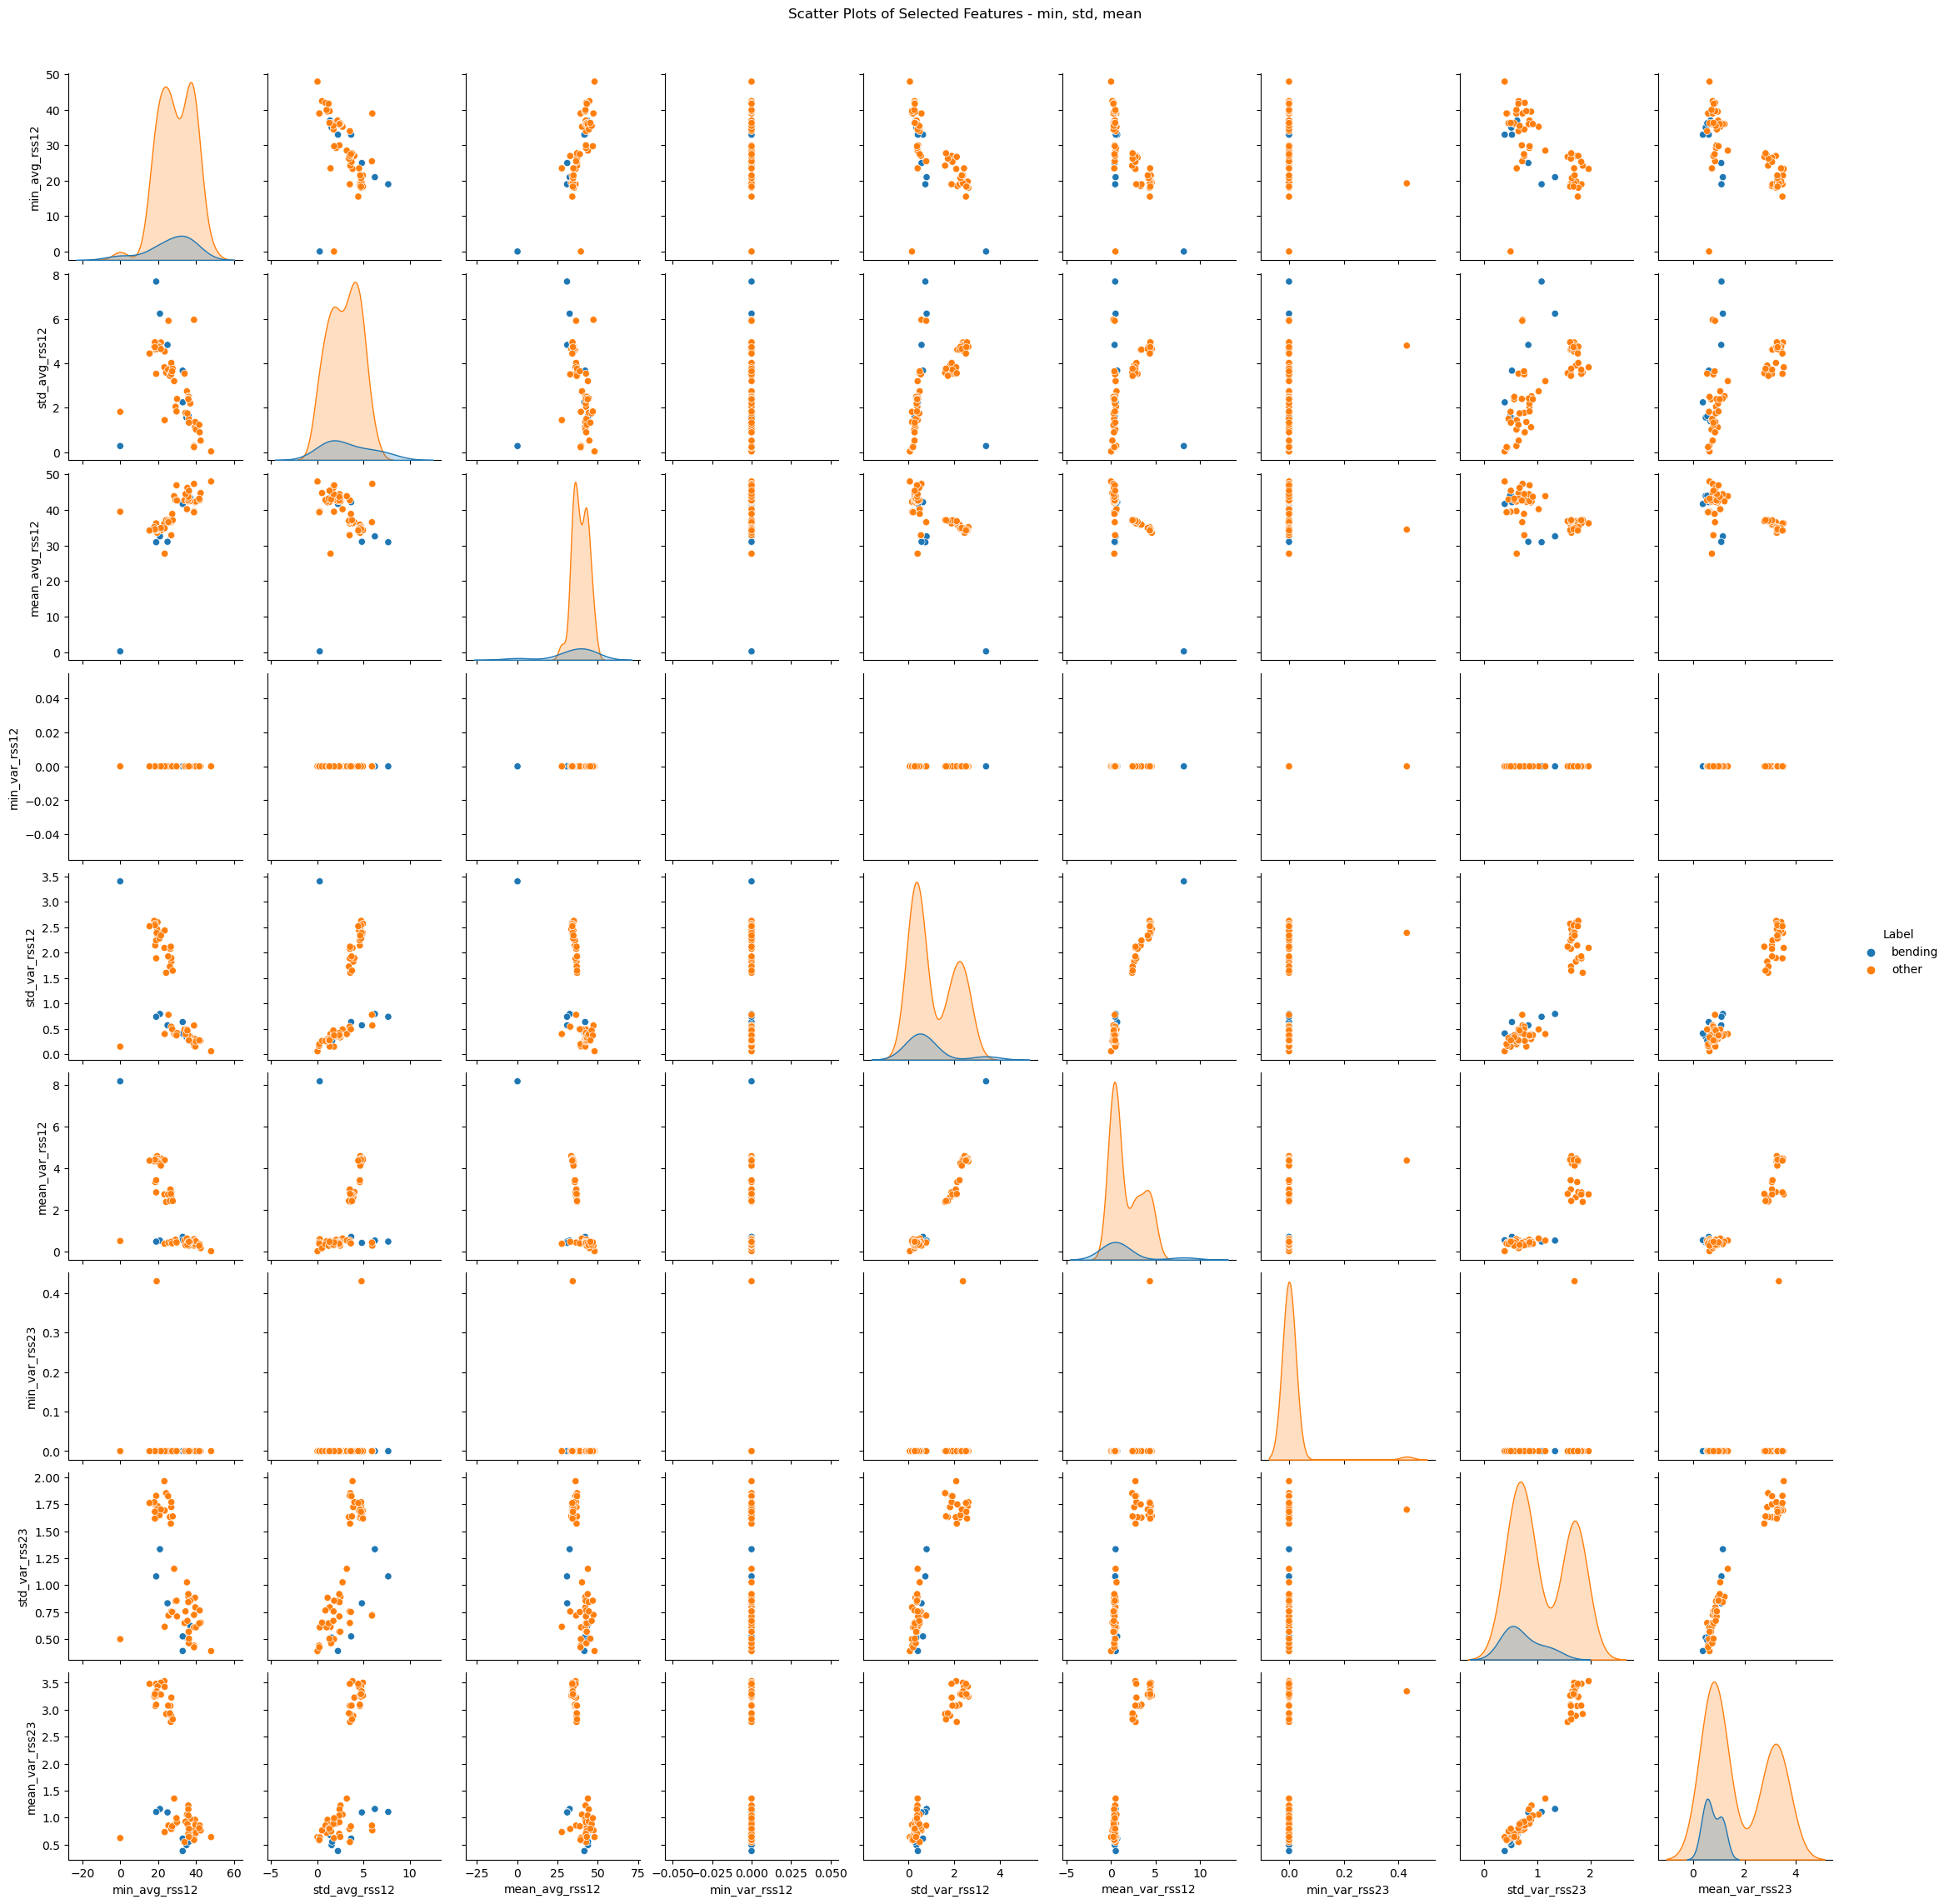

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


series_names = ['avg_rss12', 'var_rss12', 'var_rss23']  # Corresponding to time series 1, 2, 6
features_formatname = ['min', 'std', 'mean']
col_class = [f"{feature}_{series}" for series in series_names for feature in features_formatname]
col_class.append("Activity")
filtered_df = train_features_df[col_class].copy()

filtered_df['Label'] = filtered_df['Activity'].apply(lambda x: 'bending' if 'bending' in x else 'other')#refered to chatgpt for lambda

sns.pairplot(filtered_df, hue='Label', vars=col_class[:-1])  # Exclude 'Activity' from vars
plt.suptitle('Scatter Plots of Selected Features - min, std, mean', y=1.02)
plt.show()


for mean, median std and time series - 1,2,6


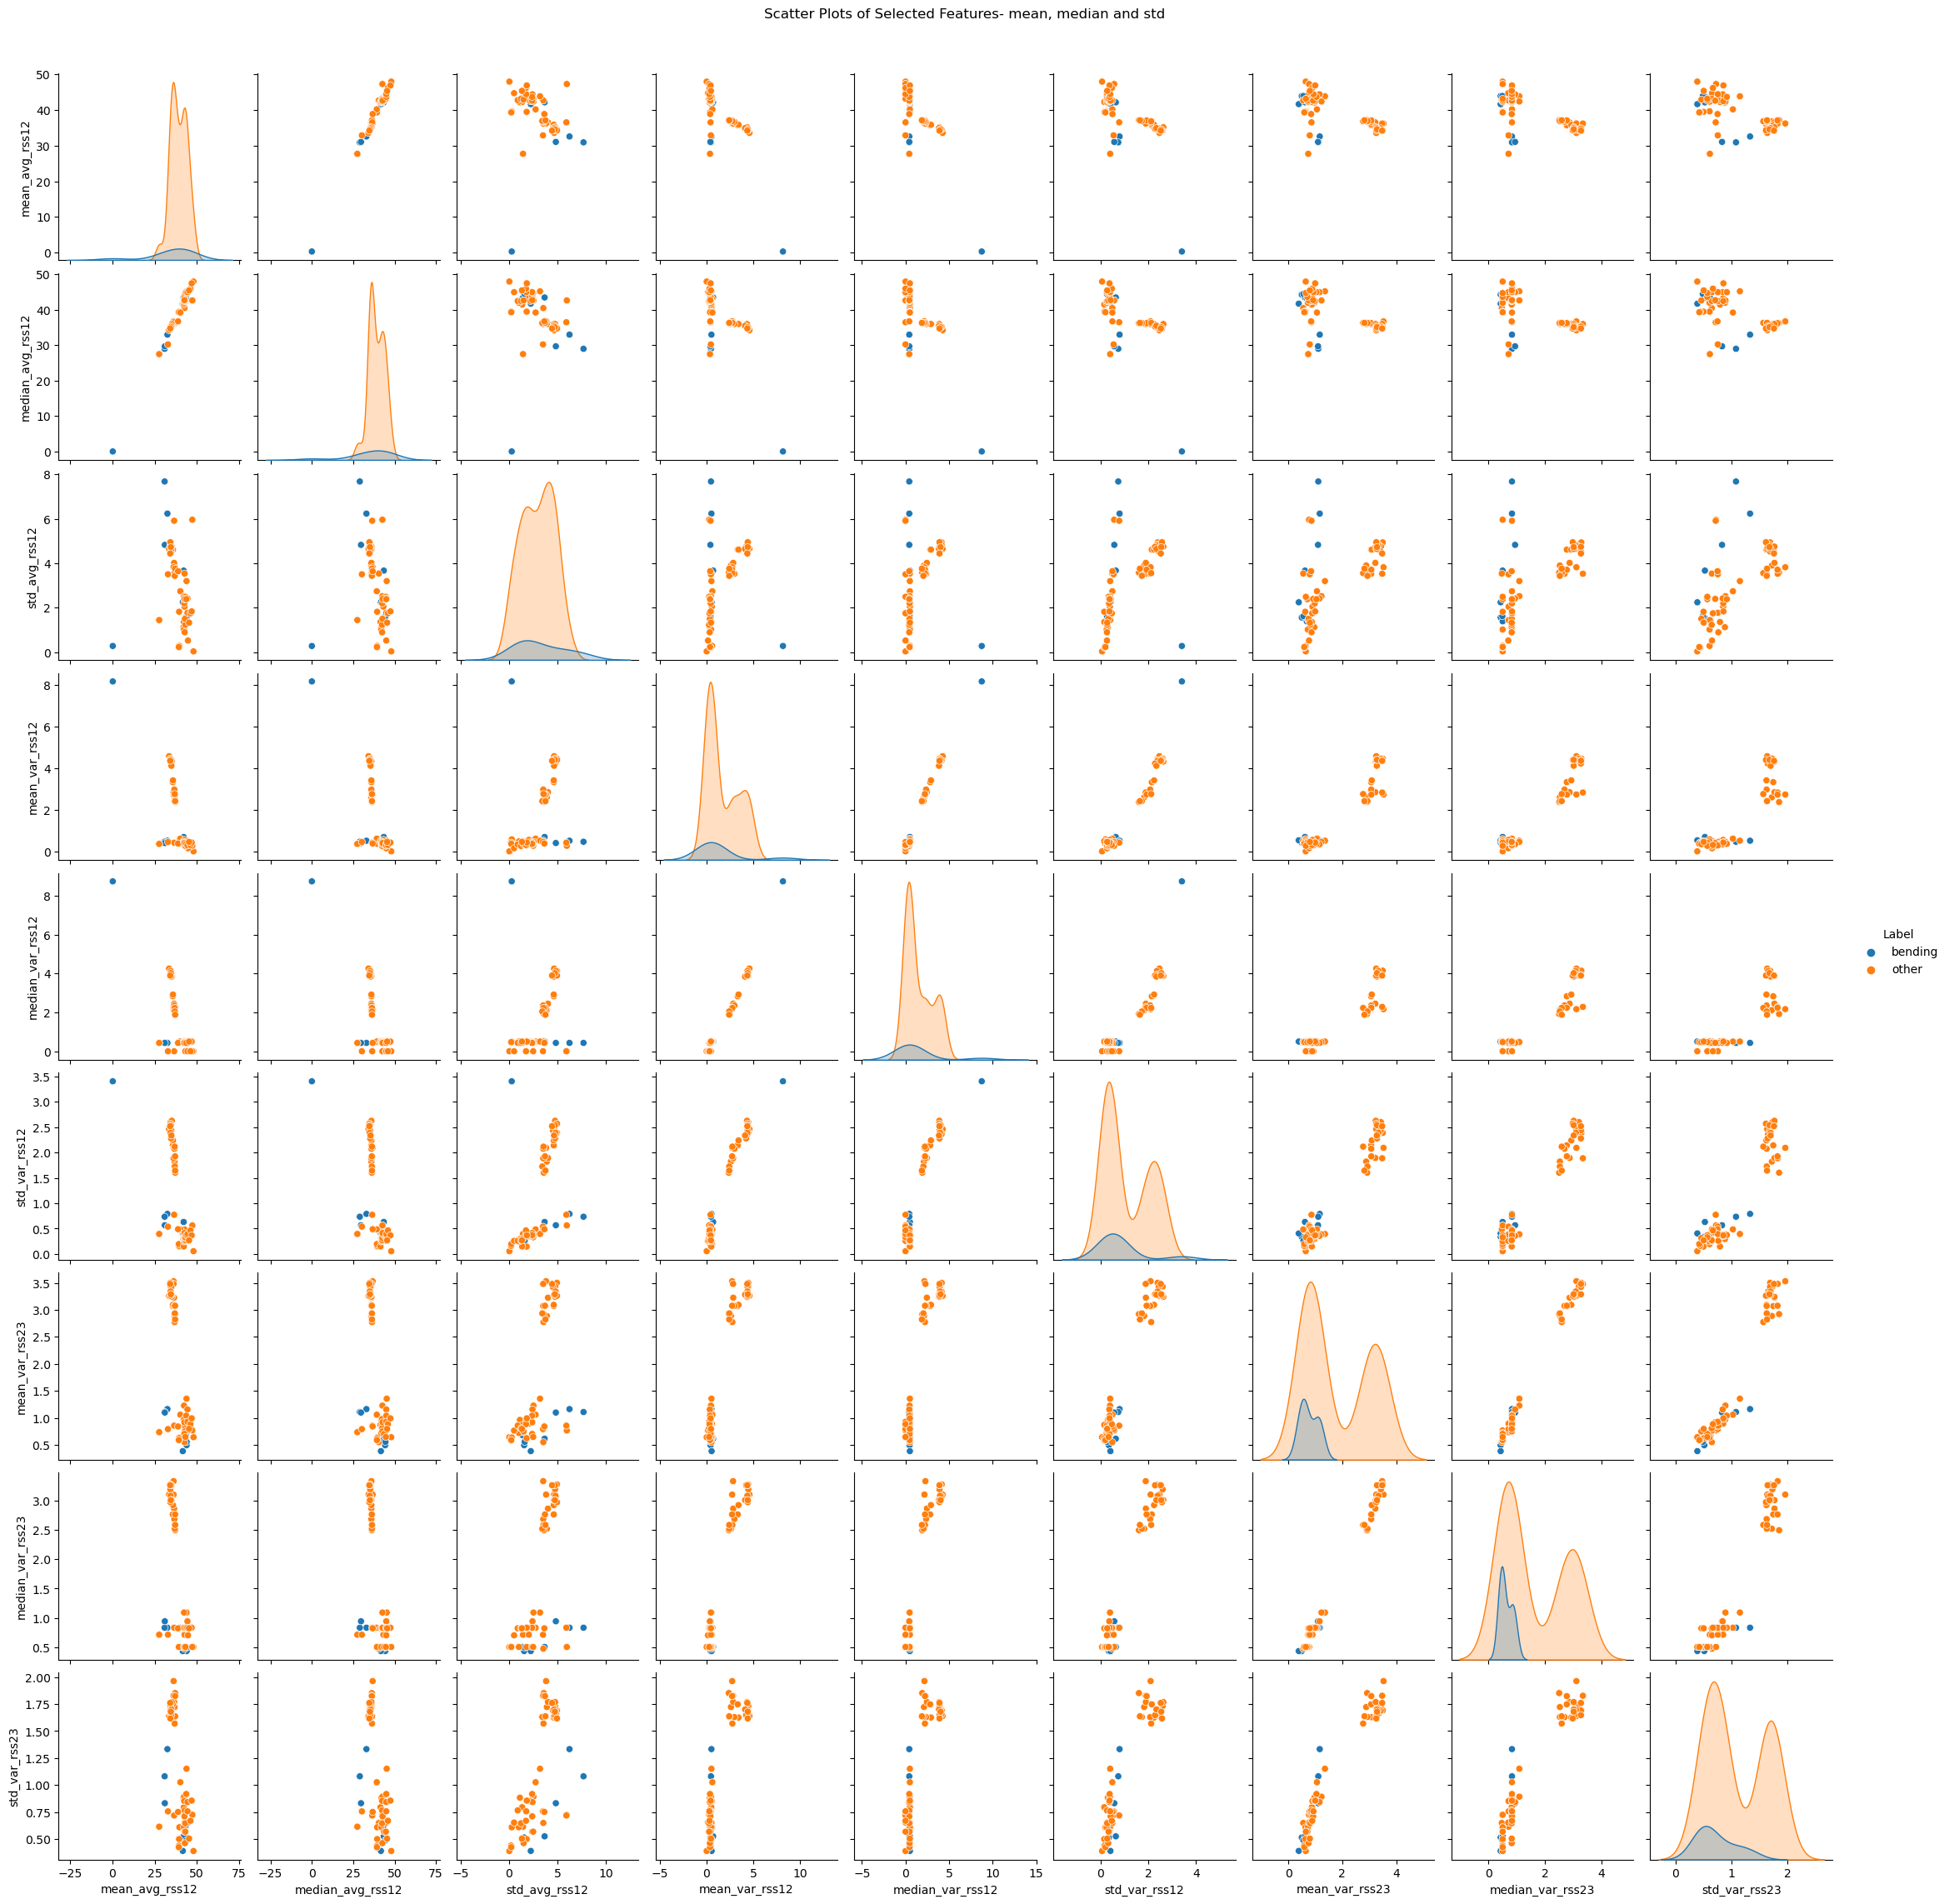

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


series_names = ['avg_rss12', 'var_rss12', 'var_rss23']  # Corresponding to time series 1, 2, 6
features_formatname = ['mean', 'median', 'std']
col_class = [f"{feature}_{series}" for series in series_names for feature in features_formatname]
col_class.append("Activity")
filtered_df_2 = train_features_df[col_class].copy()

filtered_df_2['Label'] = filtered_df['Activity'].apply(lambda x: 'bending' if 'bending' in x else 'other')#refered to chatgpt for lambda

sns.pairplot(filtered_df_2, hue='Label', vars=col_class[:-1])  # E"xclude 'Activity' from vars
plt.suptitle('Scatter Plots of Selected Features- mean, median and std', y=1.02)
plt.show()


for features - mean,median, std and time series - 3,4,5

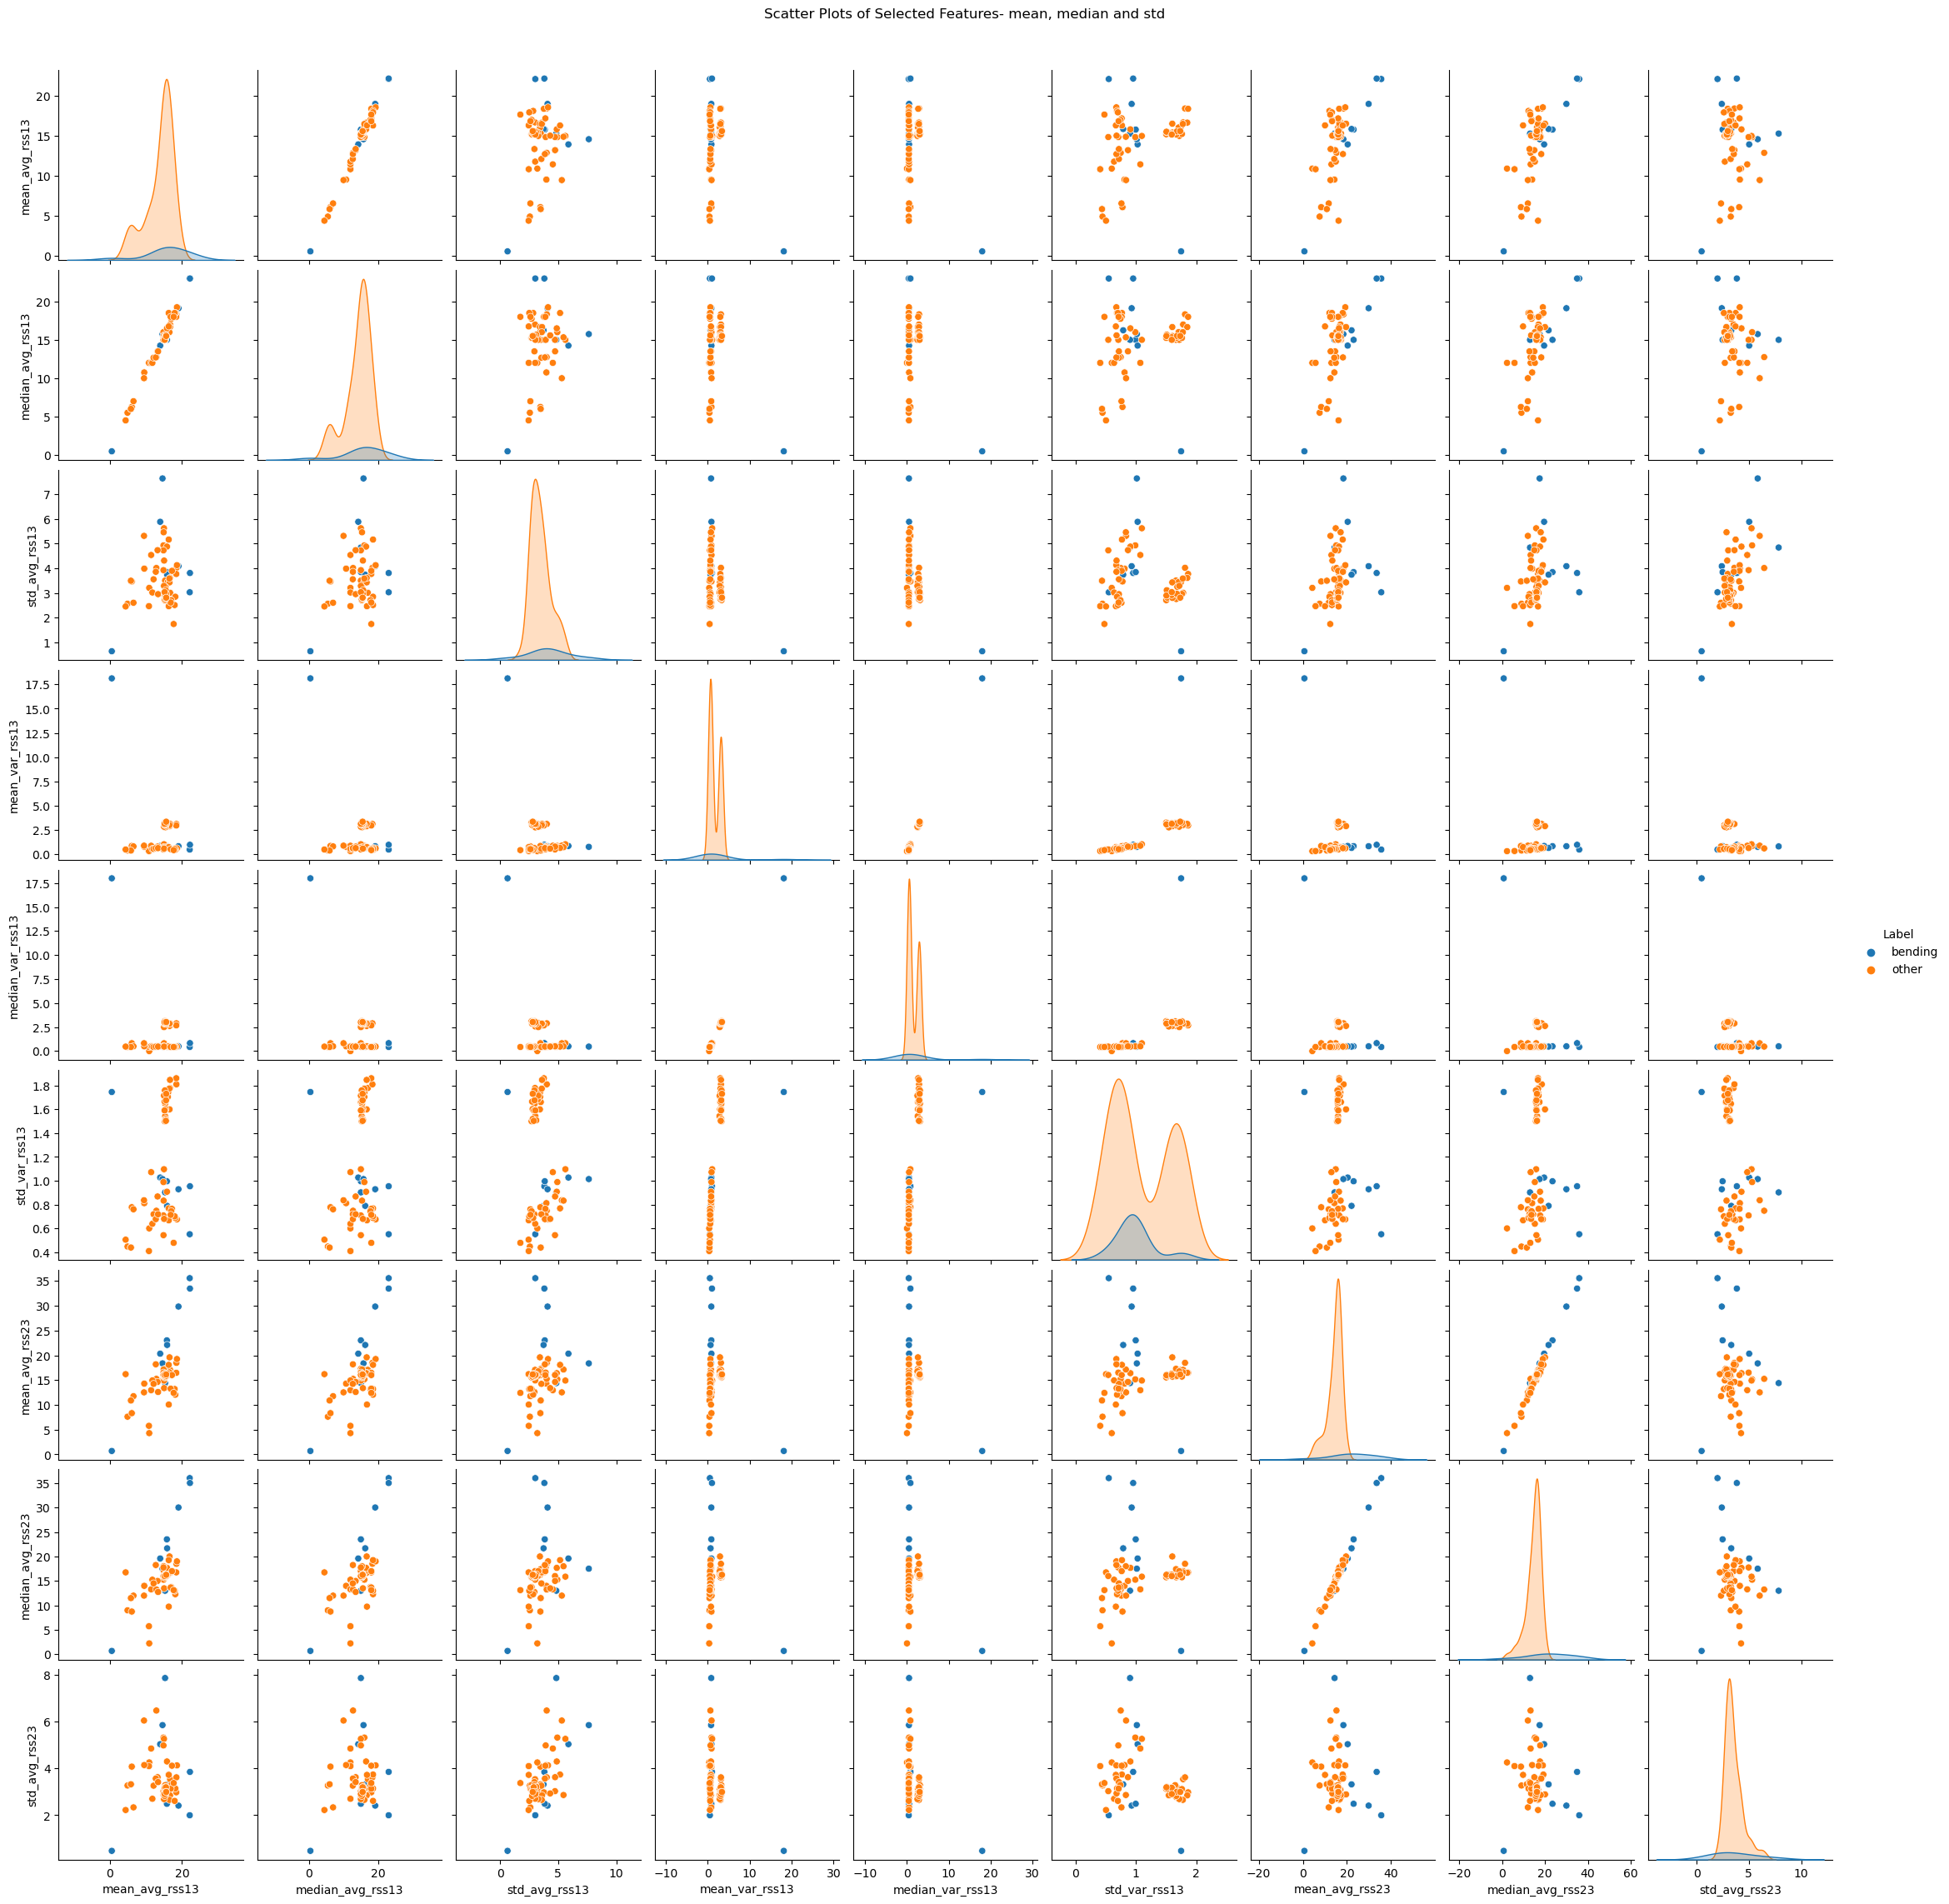

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


series_names = ['avg_rss13', 'var_rss13', 'avg_rss23']  # Corresponding to time series 1, 2, 6
features_formatname = ['mean', 'median', 'std']
col_class = [f"{feature}_{series}" for series in series_names for feature in features_formatname]
col_class.append("Activity")
filtered_df_3 = train_features_df[col_class].copy()

filtered_df_3['Label'] = filtered_df_3['Activity'].apply(lambda x: 'bending' if 'bending' in x else 'other')#refered to chatgpt for lambda

sns.pairplot(filtered_df_3, hue='Label', vars=col_class[:-1])  # Exclude 'Activity' from vars
plt.suptitle('Scatter Plots of Selected Features- mean, median and std', y=1.02)
plt.show()


HOMEWORK-5 CODE


4. Time Series Classication Part 2: Binary and Multiclass Classication
(a) Binary Classication Using Logistic Regression5
i. Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 3(c)v, i.e depict scatter plots of the features extracted from
both parts of the time series 1,2, and 6. Do you see any considerable dierence
in the results with those of 3(c)v? (5 pts)

In [134]:
import pandas as pd
import numpy as np

# Assuming filtered_df is your original dataframe
# Get the number of rows in the dataframe
n_rows = len(filtered_df_2)

# Define the mid-point of the dataframe
mid_point = n_rows // 2

# Split the dataframe into two approximately equal parts
first_half = filtered_df_2.iloc[:mid_point]
second_half = filtered_df_2.iloc[mid_point:]

# Display the first few rows of each half to check the split
print("First half:")
print(first_half.head())

print("\nSecond half:")
print(second_half.head())



First half:
   mean_avg_rss12  median_avg_rss12  std_avg_rss12  mean_var_rss12  \
0       43.954500             44.33       1.558835        0.426250   
1       42.179812             43.50       3.670666        0.696042   
2       41.678063             41.75       2.243490        0.535979   
3       43.454958             43.25       1.386098        0.378083   
4       43.969125             44.50       1.618364        0.413125   

   median_var_rss12  std_var_rss12  mean_var_rss23  median_var_rss23  \
0              0.47       0.338690        0.493292              0.43   
1              0.50       0.630860        0.613521              0.50   
2              0.50       0.405469        0.383292              0.43   
3              0.47       0.315566        0.679646              0.50   
4              0.47       0.263111        0.555312              0.49   

   std_var_rss23  Activity    Label  bending_label  
0       0.513506  bending1  bending              1  
1       0.524317  bending1  

In [143]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt


series_names = ['avg_rss12', 'var_rss12', 'var_rss23']
features_formatname = ['mean', 'median', 'std'] 


n = len(filtered_df_2)
half_n = math.floor(n / 2)


df_first_half = filtered_df_2.iloc[:half_n].reset_index(drop=True)
df_first_half = df_first_half.rename(columns=lambda x: x + "_1" if x not in ["Activity", "Label"] else x)

# Select second half of the DataFrame and rename columns
df_second_half = filtered_df_2.iloc[half_n:].reset_index(drop=True)
df_second_half = df_second_half.rename(columns=lambda x: x + "_2" if x not in ["Activity", "Label"] else x)

# Combine the two halves
combined_df = pd.concat([df_first_half, df_second_half], axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

print("Columns in combined_df:", combined_df.columns.tolist())

selected_features_first_half = [f"{feature}_{series_name}_1" for series_name in series_names for feature in features_formatname if f"{feature}_{series_name}_1" in combined_df.columns][:9]
selected_features_second_half = [f"{feature}_{series_name}_2" for series_name in series_names for feature in features_formatname if f"{feature}_{series_name}_2" in combined_df.columns][:9]

print("Selected features for the first half:", selected_features_first_half)
print("Selected features for the second half:", selected_features_second_half)

selected_features_combined = selected_features_first_half + selected_features_second_half

print("Combined selected features:", selected_features_combined)


Columns in combined_df: ['mean_avg_rss12_1', 'median_avg_rss12_1', 'std_avg_rss12_1', 'mean_var_rss12_1', 'median_var_rss12_1', 'std_var_rss12_1', 'mean_var_rss23_1', 'median_var_rss23_1', 'std_var_rss23_1', 'Activity', 'Label', 'bending_label_1', 'mean_avg_rss12_2', 'median_avg_rss12_2', 'std_avg_rss12_2', 'mean_var_rss12_2', 'median_var_rss12_2', 'std_var_rss12_2', 'mean_var_rss23_2', 'median_var_rss23_2', 'std_var_rss23_2', 'bending_label_2']
Selected features for the first half: ['mean_avg_rss12_1', 'median_avg_rss12_1', 'std_avg_rss12_1', 'mean_var_rss12_1', 'median_var_rss12_1', 'std_var_rss12_1', 'mean_var_rss23_1', 'median_var_rss23_1', 'std_var_rss23_1']
Selected features for the second half: ['mean_avg_rss12_2', 'median_avg_rss12_2', 'std_avg_rss12_2', 'mean_var_rss12_2', 'median_var_rss12_2', 'std_var_rss12_2', 'mean_var_rss23_2', 'median_var_rss23_2', 'std_var_rss23_2']
Combined selected features: ['mean_avg_rss12_1', 'median_avg_rss12_1', 'std_avg_rss12_1', 'mean_var_rss12

18


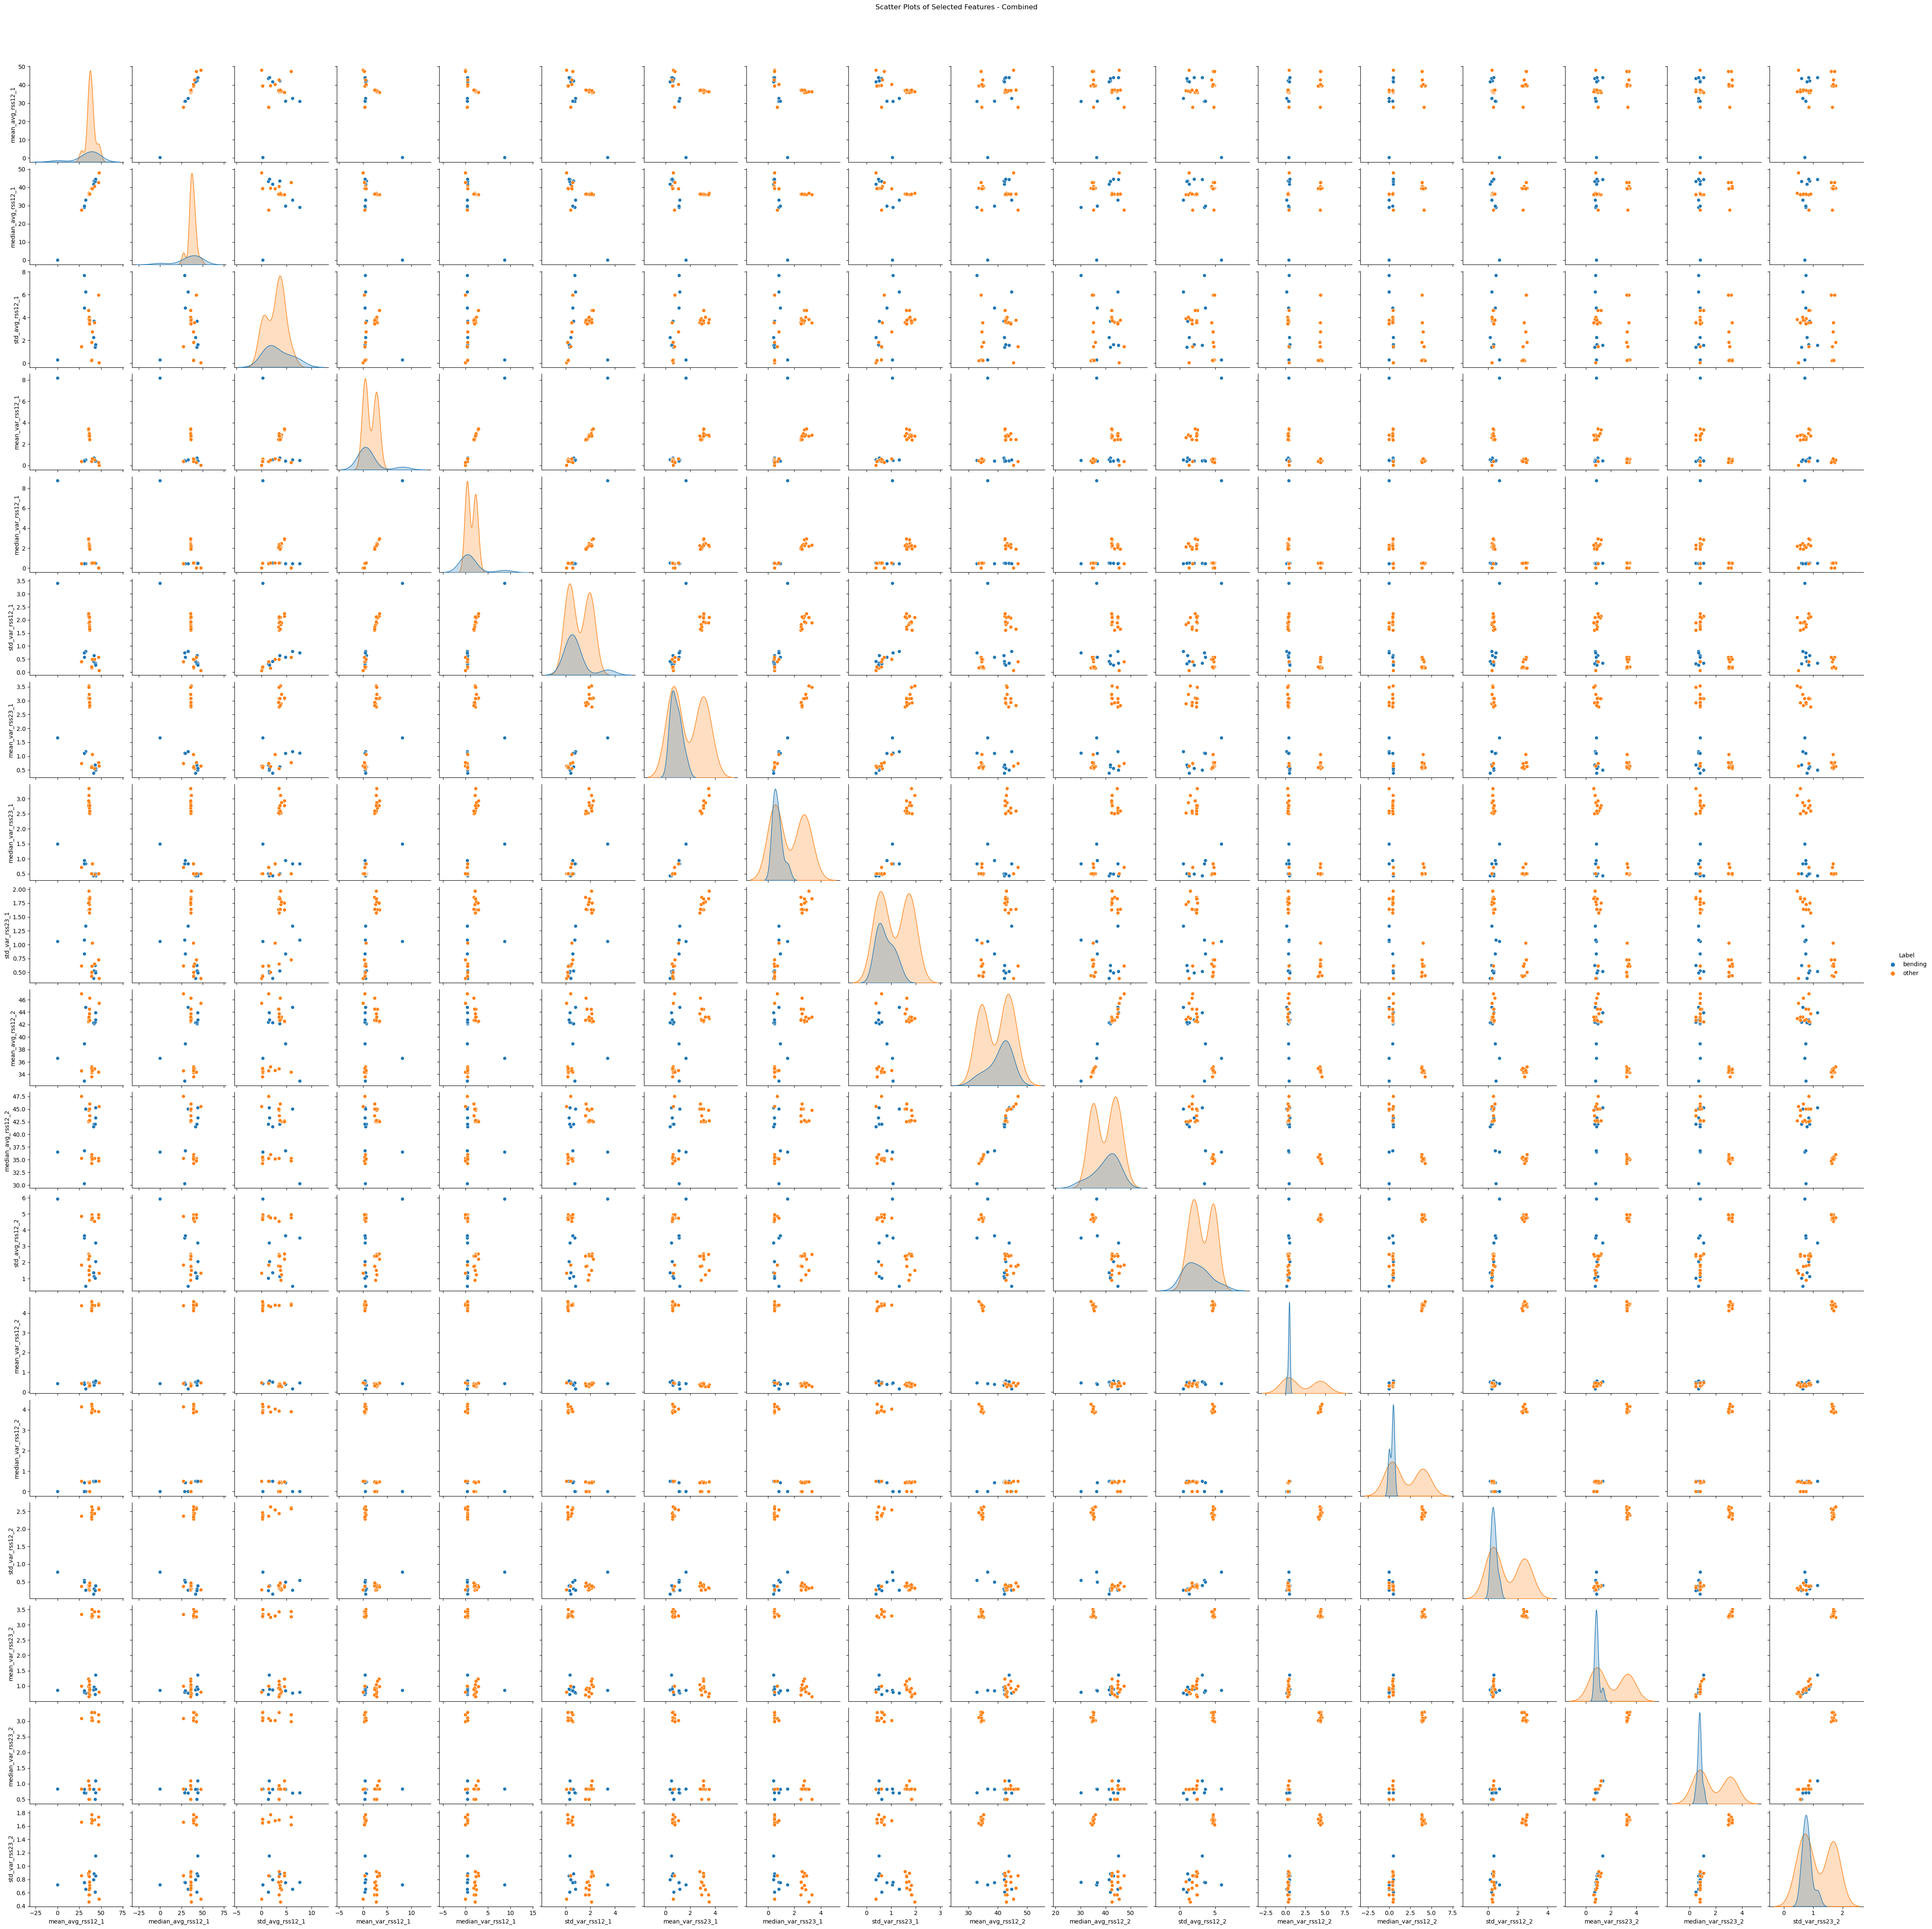

In [146]:
print(len(selected_features_combined))

if selected_features_combined:
    sns.pairplot(combined_df, hue='Label', vars=selected_features_combined)
    plt.suptitle('Scatter Plots of Selected Features - Combined', y=1.02)
    plt.show()
else:
    print("No valid features found for the combined data.")


Conclusion- 
The separation between 'bending' and 'other' appears to be more pronounced after dividing the time series.
Certain features show clearer separation, potentially indicating improved feature informativeness.

This suggests that dividing the time series improves the separation between classes and potentially improves classification performance.

In [1]:
base_path ='F:\AssignmentsUSC\Homework5\data'

In [74]:
import pandas as pd
import numpy as np
import os

folders = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
test_instances = {
    "bending1": [1, 2],
    "bending2": [1, 2],
    "cycling": [1, 2, 3],
    "lying": [1, 2, 3],
    "sitting": [1, 2, 3],
    "standing": [1, 2, 3],
    "walking": [1, 2, 3]
}

# Initialize lists to hold train and test data
train_data = []
test_data = []

# Function to load and split instance data
def load_and_split_instance_data(folder, instance_index):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    half_len = df.shape[0] // 2
    
    # Split each column into two halves
    first_half = df.iloc[:half_len, :]
    second_half = df.iloc[half_len:, :].reset_index(drop=True)
    
    # Rename columns for the second half
    second_half.columns = [f"{col}_part2" for col in second_half.columns]
    
    # Concatenate first and second halves
    combined_df = pd.concat([first_half, second_half], axis=1)
    
    # Add activity column
    combined_df['Activity'] = folder
    
    return combined_df

# Load, split, and combine the data into train and test sets
for folder in folders:
    num_instances = len(os.listdir(os.path.join(base_path, folder)))
    for i in range(1, num_instances + 1):
        data = load_and_split_instance_data(folder, i)
        if i in test_instances[folder]:
            test_data.append(data)
        else:
            train_data.append(data)

# Combine the train and test data into single DataFrames
train_df = pd.concat(train_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

print(f"Number of training instances: {len(train_data)}")
print(f"Number of test instances: {len(test_data)}")

print(f"Number of training data points: {train_df.shape[0]}")
print(f"Number of test data points: {test_df.shape[0]}")

# Display the first few rows of the training and test sets
print("\nTraining Data Sample:")
print(train_df.head())

print("\nTest Data Sample:")
print(test_df.head())


Number of training instances: 69
Number of test instances: 19
Number of training data points: 16799
Number of test data points: 4560

Training Data Sample:
   avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0      42.00       0.71      21.25       0.43      30.00       0.00   
1      41.50       0.50      20.25       1.48      31.25       1.09   
2      41.50       0.50      14.25       1.92      33.00       0.00   
3      40.75       0.83      15.75       0.43      33.00       0.00   
4      40.00       0.71      20.00       2.74      32.75       0.43   

   avg_rss12_part2  var_rss12_part2  avg_rss13_part2  var_rss13_part2  \
0            43.33             0.94            18.00             0.00   
1            44.20             0.75            19.75             0.83   
2            45.00             0.00            21.75             0.83   
3            45.00             0.00            23.33             0.47   
4            45.00             0.00            24.00

In [103]:
base_path ='F:\AssignmentsUSC\Homework4\homework-4-niveditha-7\data'

In [130]:

# Define the folders and the split criteria
folders = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
test_instances = {
    "bending1": [1, 2],
    "bending2": [1, 2],
    "cycling": [1, 2, 3],
    "lying": [1, 2, 3],
    "sitting": [1, 2, 3],
    "standing": [1, 2, 3],
    "walking": [1, 2, 3]
}

# Function to load and split instance data into l segments
def load_and_split_instance_data(folder, instance_index, l):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    # Check for NaN values in the original DataFrame
    if df.isnull().values.any():
        print(f"NaN values found in original data for {folder}/dataset{instance_index}")
    
    # Verify the number of rows in the original DataFrame
    if df.shape[0] not in [479, 480]:
        print(f"Skipping instance {folder}/dataset{instance_index} due to unexpected row count: {df.shape[0]}")
        return None
    
    # Split each column into l segments
    segment_length = df.shape[0] // l
    segments = []
    for i in range(l):
        start = i * segment_length
        end = start + segment_length if i != l-1 else df.shape[0]
        segment = df.iloc[start:end].reset_index(drop=True)
        
        # Check for NaN values in the segments
        if segment.isnull().values.any():
            print(f"NaN values found in segment {i} for {folder}/dataset{instance_index}")
        
        segments.append(segment)
    
    return segments
#using extract feature from previous cell
# Load, split, and extract features from the data
def prepare_data(folders, test_instances, l):
    def process_instance(folder, instance_index, l):
        segments = load_and_split_instance_data(folder, instance_index, l)
        if segments is not None:
            features = extract_features(segments)
            # Combine bending1 and bending2 into a single class "bending"
            activity = "bending" if folder in ["bending1", "bending2"] else folder
            features['Activity'] = 1 if activity == "bending" else 0
            # Check for NaN values in features
            if pd.DataFrame([features]).isnull().values.any():
                print(f"NaN values found in extracted features for {folder}/dataset{instance_index}")
            if instance_index in test_instances[folder]:
                return 'test', features
            else:
                return 'train', features
        return None

    results = Parallel(n_jobs=-1)(delayed(process_instance)(folder, instance_index, l) for folder in folders for instance_index in range(1, len(os.listdir(os.path.join(base_path, folder))) + 1))
    train_data = [result[1] for result in results if result and result[0] == 'train']
    test_data = [result[1] for result in results if result and result[0] == 'test']

    return pd.DataFrame(train_data), pd.DataFrame(test_data)

# Train logistic regression and perform feature selection
def train_and_evaluate_model(X, y, k=5):
    # Handle NaN values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    # Initialize logistic regression model with default solver (lbfgs)
    model = LogisticRegression(max_iter=5000)
    
    # Perform feature selection using RFECV
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(n_splits=k), scoring='accuracy')
    rfecv.fit(X, y)
    
    return rfecv.n_features_, np.max(rfecv.cv_results_['mean_test_score'])

# Main logic
results = []

for l in range(1, 21):
    train_df, test_df = prepare_data(folders, test_instances, l)
    
    # Check for class balance in training data
    class_counts = train_df['Activity'].value_counts()
    if class_counts.min() < 5:
        print(f"Skipping l={l} due to insufficient class samples for stratified k-fold.")
        continue
    
    X_train = train_df.drop('Activity', axis=1)
    y_train = train_df['Activity']
    num_features = X_train.shape[1]  # Number of features

    print(f"For l={l}, number of features before RFE: {num_features}")  # Print number of features before RFE
    num_features_selected, mean_score = train_and_evaluate_model(X_train, y_train)
    results.append((l, num_features_selected, mean_score))
    print(f'For l={l}: Optimal number of features after RFE = {num_features_selected}, Cross-validation score = {mean_score}')

# Find the best model based on cross-validation score
best_result = max(results, key=lambda x: x[2])
best_l, best_p, best_cv_score = best_result

# Output the results
print("\nOptimal number of features for each l:")
for result in results:
    l, p, mean_score = result
    if l == best_l:
        print(f"Optimal number of features for l = {l} is {p}")
        print(f"Cross-validation score: {mean_score}")

print(f"\nBest model: l = {best_l}, p = {best_p}")
print(f"Cross-validation score = {best_cv_score}")


For l=1, number of features before RFE: 18
For l=1: Optimal number of features after RFE = 6, Cross-validation score = 0.9560439560439562
For l=2, number of features before RFE: 36
For l=2: Optimal number of features after RFE = 10, Cross-validation score = 0.9274725274725275
For l=3, number of features before RFE: 54
For l=3: Optimal number of features after RFE = 1, Cross-validation score = 0.9571428571428573
For l=4, number of features before RFE: 72
For l=4: Optimal number of features after RFE = 1, Cross-validation score = 0.9428571428571428
For l=5, number of features before RFE: 90
For l=5: Optimal number of features after RFE = 1, Cross-validation score = 0.9417582417582417
For l=6, number of features before RFE: 108
For l=6: Optimal number of features after RFE = 1, Cross-validation score = 0.9571428571428573
For l=7, number of features before RFE: 126
For l=7: Optimal number of features after RFE = 2, Cross-validation score = 0.9428571428571428
For l=8, number of features bef


The right way to perform cross-validation involves conducting preprocessing, feature selection, and hyperparameter tuning within each fold to avoid information leakage. This ensures that the model's performance is evaluated fairly without overfitting to the validation data.

Wrong way - Pre processing and Feature Selection Outside Cross-Validation Loop. Causes overfitting because feature selection is performed on the entire dataset, allowing the validation set to influence which features are selected.

Confusion Matrix:
 [[60  0]
 [ 2  7]]


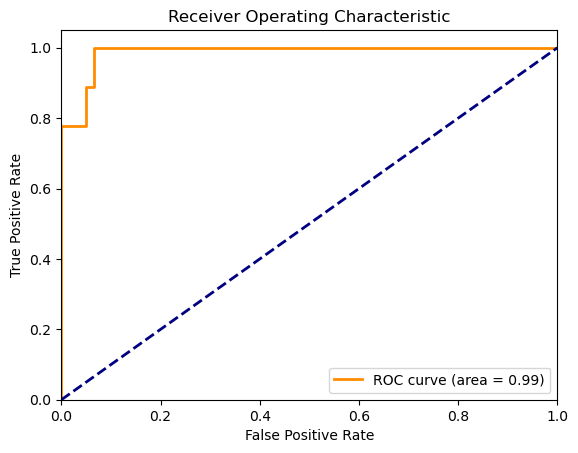

ROC AUC: 0.987037037037037
Optimization terminated successfully.
         Current function value: 0.092705
         Iterations 10

Parameters and p-values:
                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       67
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Jul 2024   Pseudo R-squ.:                  0.7606
Time:                        17:25:48   Log-Likelihood:                -6.3967
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.828e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.6297      8.779     -2.578      0.010

In [139]:

def load_and_split_instance_data(folder, instance_index, l):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    # Split each column into l segments
    segment_length = df.shape[0] // l
    segments = []
    for i in range(l):
        start = i * segment_length
        end = start + segment_length if i != l-1 else df.shape[0]
        segment = df.iloc[start:end].reset_index(drop=True)
        segments.append(segment)
    return segments


def prepare_data(folders, test_instances, l):
    def process_instance(folder, instance_index, l):
        segments = load_and_split_instance_data(folder, instance_index, l)
        if segments is not None:
            features = extract_features(segments)
            # Combine bending1 and bending2 into a single class "bending"
            activity = "bending" if folder in ["bending1", "bending2"] else folder
            features['Activity'] = 1 if activity == "bending" else 0
            if instance_index in test_instances[folder]:
                return 'test', features
            else:
                return 'train', features
        return None

    results = Parallel(n_jobs=-1)(delayed(process_instance)(folder, instance_index, l) for folder in folders for instance_index in range(1, len(os.listdir(os.path.join(base_path, folder))) + 1))
    train_data = [result[1] for result in results if result and result[0] == 'train']
    test_data = [result[1] for result in results if result and result[0] == 'test']

    return pd.DataFrame(train_data), pd.DataFrame(test_data)

# Using best_l and best_p 
best_l = 9
best_p = 1

# Prepare the data using best_l
train_df, test_df = prepare_data(folders, test_instances, best_l)

X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

# Train the model with the optimal number of features (best_p)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

model = LogisticRegression(max_iter=5000)
rfe = RFE(estimator=model, n_features_to_select=best_p)
rfe.fit(X_train_imputed, y_train)

# Predictions
y_train_pred = rfe.predict(X_train_imputed)

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC and AUC
y_train_prob = rfe.predict_proba(X_train_imputed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'ROC AUC: {roc_auc}')

# Parameters and p-values
X_train_selected = X_train_imputed[:, rfe.support_]
X_train_sm = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

print("\nParameters and p-values:")
print(result.summary())


In [146]:


def load_and_split_instance_data(folder, instance_index, l):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    # Split each column into l segments
    segment_length = df.shape[0] // l
    segments = []
    for i in range(l):
        start = i * segment_length
        end = start + segment_length if i != l-1 else df.shape[0]
        segment = df.iloc[start:end].reset_index(drop=True)
        segments.append(segment)
    return segments


def prepare_data(folders, test_instances, l):
    def process_instance(folder, instance_index, l):
        segments = load_and_split_instance_data(folder, instance_index, l)
        if segments is not None:
            features = extract_features(segments)
            # Combine bending1 and bending2 into a single class "bending"
            activity = "bending" if folder in ["bending1", "bending2"] else folder
            features['Activity'] = 1 if activity == "bending" else 0
            if instance_index in test_instances[folder]:
                return 'test', features
            else:
                return 'train', features
        return None

    results = Parallel(n_jobs=-1)(delayed(process_instance)(folder, instance_index, l) for folder in folders for instance_index in range(1, len(os.listdir(os.path.join(base_path, folder))) + 1))
    train_data = [result[1] for result in results if result and result[0] == 'train']
    test_data = [result[1] for result in results if result and result[0] == 'test']

    return pd.DataFrame(train_data), pd.DataFrame(test_data)

# Using best_l and best_p from your previous output
best_l = 9
best_p = 1

# Prepare the data using best_l
train_df, test_df = prepare_data(folders, test_instances, best_l)

X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

# Train the model with the optimal number of features (best_p)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model = LogisticRegression(max_iter=5000)
rfe = RFE(estimator=model, n_features_to_select=best_p)
rfe.fit(X_train_imputed, y_train)

# Predictions on the test set
y_test_pred = rfe.predict(X_test_imputed)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Compare with cross-validation accuracy
cross_val_accuracy = 0.9714285714285715  # Example value from previous output
print(f"Cross-validation Accuracy: {cross_val_accuracy}")

# Confusion Matrix on the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix on Test Set:\n", conf_matrix_test)


Test Accuracy: 0.9473684210526315
Cross-validation Accuracy: 0.9714285714285715
Confusion Matrix on Test Set:
 [[15  0]
 [ 1  3]]


Both the test accuracy and the cross-validation accuracy are very high (around 0.95 and 0.97, respectively), indicating that the model performs consistently well on both the training and test data.



v. Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?

answer-
The warning about "complete quasi-separation" in the logistic regression summary suggests that a fraction of observations can be perfectly predicted.
In this case, some parameters might not be identified properly, which can be a sign that the classes are very well-separated.
answer- 

From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

answer- Both the training and test sets show a noticeable imbalance between the classes.
In the training set, Class 0 (Non-Bending) instances significantly outnumber Class 1 (Bending) instances by a ratio of about 7:1.
In the test set, Class 0 (Non-Bending) instances also outnumber Class 1 (Bending) instances, but the ratio is closer to 4:1.

Training Accuracy: 0.9083333333333333
Confusion Matrix on Training Set:
 [[56  4]
 [ 7 53]]


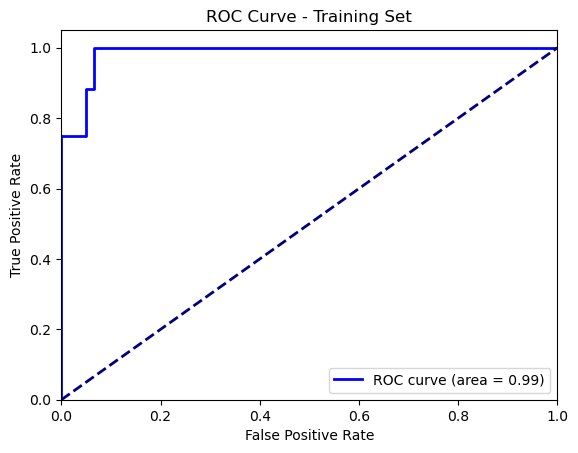

ROC AUC on Training Set: 0.9855555555555555
Test Accuracy: 0.8421052631578947
Confusion Matrix on Test Set:
 [[13  2]
 [ 1  3]]


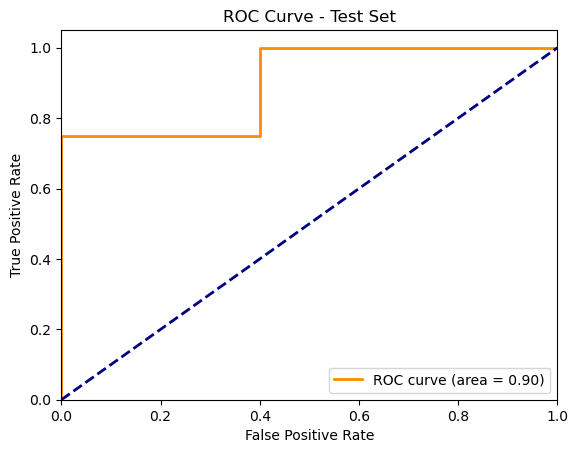

ROC AUC on Test Set: 0.9
Optimization terminated successfully.
         Current function value: 0.156031
         Iterations 11

Parameters and p-values on the Training Set:
                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Jul 2024   Pseudo R-squ.:                  0.7749
Time:                        19:33:49   Log-Likelihood:                -18.724
converged:                       True   LL-Null:                       -83.178
Covariance Type:            nonrobust   LLR p-value:                 7.104e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.9273      8.063    

In [150]:
from sklearn.utils import resample

best_l = 9
best_p = 1


train_df, test_df = prepare_data(folders, test_instances, best_l)

# Perform case-control sampling on the training data
class_0 = train_df[train_df['Activity'] == 0]
class_1 = train_df[train_df['Activity'] == 1]

# Upsample minority class
class_1_upsampled = resample(class_1,
                             replace=True,  # sample with replacement
                             n_samples=len(class_0),  # to match majority class
                             random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
train_df_balanced = pd.concat([class_0, class_1_upsampled])

X_train = train_df_balanced.drop('Activity', axis=1)
y_train = train_df_balanced['Activity']

X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

# Train the model with the optimal number of features (best_p)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model = LogisticRegression(max_iter=5000)
rfe = RFE(estimator=model, n_features_to_select=best_p)
rfe.fit(X_train_imputed, y_train)


y_train_pred = rfe.predict(X_train_imputed)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Confusion Matrix on the training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix on Training Set:\n", conf_matrix_train)

# ROC and AUC on the training set
y_train_prob = rfe.predict_proba(X_train_imputed)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()

print(f'ROC AUC on Training Set: {roc_auc_train}')


y_test_pred = rfe.predict(X_test_imputed)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix on the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix on Test Set:\n", conf_matrix_test)

# ROC and AUC on the test set
y_test_prob = rfe.predict_proba(X_test_imputed)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.show()

print(f'ROC AUC on Test Set: {roc_auc_test}')

# Parameters and p-values on the training set
X_train_selected = X_train_imputed[:, rfe.support_]
X_train_sm = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

print("\nParameters and p-values on the Training Set:")
print(result.summary())


In [153]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed


# Function to load and split instance data into l segments
def load_and_split_instance_data(folder, instance_index, l):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    # Check for NaN values in the original DataFrame
    if df.isnull().values.any():
        print(f"NaN values found in original data for {folder}/dataset{instance_index}")
    
    # Verify the number of rows in the original DataFrame
    if df.shape[0] not in [479, 480]:
        print(f"Skipping instance {folder}/dataset{instance_index} due to unexpected row count: {df.shape[0]}")
        return None
    
    # Split each column into l segments
    segment_length = df.shape[0] // l
    segments = []
    for i in range(l):
        start = i * segment_length
        end = start + segment_length if i != l-1 else df.shape[0]
        segment = df.iloc[start:end].reset_index(drop=True)
        
        # Check for NaN values in the segments
        if segment.isnull().values.any():
            print(f"NaN values found in segment {i} for {folder}/dataset{instance_index}")
        
        segments.append(segment)
    
    return segments

# Load, split, and extract features from the data
def prepare_data(folders, test_instances, l):
    def process_instance(folder, instance_index, l):
        segments = load_and_split_instance_data(folder, instance_index, l)
        if segments is not None:
            features = extract_features(segments)
            # Combine bending1 and bending2 into a single class "bending"
            activity = "bending" if folder in ["bending1", "bending2"] else folder
            features['Activity'] = 1 if activity == "bending" else 0
            # Check for NaN values in features
            if pd.DataFrame([features]).isnull().values.any():
                print(f"NaN values found in extracted features for {folder}/dataset{instance_index}")
            if instance_index in test_instances[folder]:
                return 'test', features
            else:
                return 'train', features
        return None

    results = Parallel(n_jobs=-1)(delayed(process_instance)(folder, instance_index, l) for folder in folders for instance_index in range(1, len(os.listdir(os.path.join(base_path, folder))) + 1))
    train_data = [result[1] for result in results if result and result[0] == 'train']
    test_data = [result[1] for result in results if result and result[0] == 'test']

    return pd.DataFrame(train_data), pd.DataFrame(test_data)

# Train logistic regression with L1 regularization and perform feature selection
def train_and_evaluate_model(X, y, l, c_values, k=5):
    # Handle NaN values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Initialize logistic regression model with L1 regularization
    model = LogisticRegressionCV(Cs=c_values, cv=StratifiedKFold(n_splits=k), penalty='l1', solver='liblinear', max_iter=5000, scoring='accuracy')
    
    # Perform feature selection using RFECV
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(n_splits=k), scoring='accuracy')
    rfecv.fit(X, y)
    
    return rfecv.n_features_, np.max(rfecv.cv_results_['mean_test_score'])

results = []

# Define range of C values for cross-validation
c_values = np.logspace(-4, 4, 10)

for l in range(1, 21):
    train_df, test_df = prepare_data(folders, test_instances, l)
    
    # Check for class balance in training data
    class_counts = train_df['Activity'].value_counts()
    if class_counts.min() < 5:
        print(f"Skipping l={l} due to insufficient class samples for stratified k-fold.")
        continue
    
    X_train = train_df.drop('Activity', axis=1)
    y_train = train_df['Activity']
    num_features = X_train.shape[1]  # Number of features

    print(f"For l={l}, number of features before RFE: {num_features}")  # Print number of features before RFE
    num_features_selected, mean_score = train_and_evaluate_model(X_train, y_train, l, c_values)
    results.append((l, num_features_selected, mean_score))
    print(f'For l={l}: Optimal number of features after RFE = {num_features_selected}, Cross-validation score = {mean_score}')

# Find the best model based on cross-validation score
best_result = max(results, key=lambda x: x[2])
best_l, best_p, best_cv_score = best_result

# Output the results
print("\nOptimal number of features for each l:")
for result in results:
    l, p, mean_score = result
    if l == best_l:
        print(f"Optimal number of features for l = {l} is {p}")
        print(f"Cross-validation score: {mean_score}")

print(f"\nBest model: l = {best_l}, p = {best_p}")
print(f"Cross-validation score = {best_cv_score}")


For l=1, number of features before RFE: 18
For l=1: Optimal number of features after RFE = 1, Cross-validation score = 0.9274725274725275
For l=2, number of features before RFE: 36
For l=2: Optimal number of features after RFE = 24, Cross-validation score = 0.9571428571428573
For l=3, number of features before RFE: 54
For l=3: Optimal number of features after RFE = 1, Cross-validation score = 0.9714285714285715
For l=4, number of features before RFE: 72
For l=4: Optimal number of features after RFE = 4, Cross-validation score = 0.9714285714285715
For l=5, number of features before RFE: 90
For l=5: Optimal number of features after RFE = 1, Cross-validation score = 0.9571428571428573
For l=6, number of features before RFE: 108
For l=6: Optimal number of features after RFE = 1, Cross-validation score = 0.9714285714285715
For l=7, number of features before RFE: 126
For l=7: Optimal number of features after RFE = 1, Cross-validation score = 0.9571428571428573
For l=8, number of features bef

Training Accuracy: 0.9710144927536232
Confusion Matrix on Training Set:
 [[60  0]
 [ 2  7]]
ROC AUC on Training Set: 0.9981481481481481


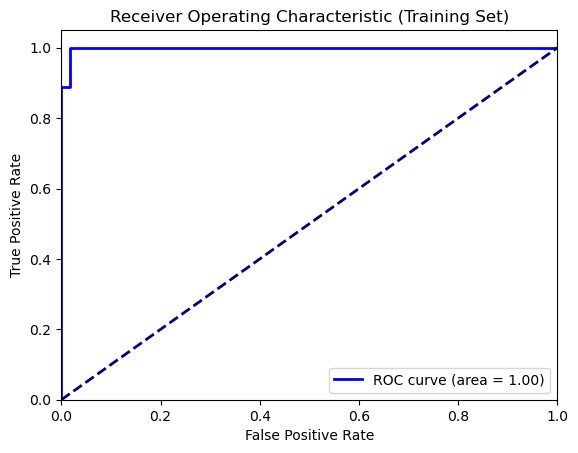


Coefficients and p-values:
Feature 1: Coefficient = 1.6759, p-value = 0.0000
Feature 2: Coefficient = -0.3155, p-value = 0.0000


In [156]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


# Function to load and split instance data into l segments
def load_and_split_instance_data(folder, instance_index, l):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    # Check for NaN values in the original DataFrame
    if df.isnull().values.any():
        print(f"NaN values found in original data for {folder}/dataset{instance_index}")
    
    # Verify the number of rows in the original DataFrame
    if df.shape[0] not in [479, 480]:
        print(f"Skipping instance {folder}/dataset{instance_index} due to unexpected row count: {df.shape[0]}")
        return None
    
    # Split each column into l segments
    segment_length = df.shape[0] // l
    segments = []
    for i in range(l):
        start = i * segment_length
        end = start + segment_length if i != l-1 else df.shape[0]
        segment = df.iloc[start:end].reset_index(drop=True)
        
        # Check for NaN values in the segments
        if segment.isnull().values.any():
            print(f"NaN values found in segment {i} for {folder}/dataset{instance_index}")
        
        segments.append(segment)
    
    return segments

# Load, split, and extract features from the data
def prepare_data(folders, test_instances, l):
    def process_instance(folder, instance_index, l):
        segments = load_and_split_instance_data(folder, instance_index, l)
        if segments is not None:
            features = extract_features(segments)
            # Combine bending1 and bending2 into a single class "bending"
            activity = "bending" if folder in ["bending1", "bending2"] else folder
            features['Activity'] = 1 if activity == "bending" else 0
            if instance_index in test_instances[folder]:
                return 'test', features
            else:
                return 'train', features
        return None

    results = Parallel(n_jobs=-1)(delayed(process_instance)(folder, instance_index, l) for folder in folders for instance_index in range(1, len(os.listdir(os.path.join(base_path, folder))) + 1))
    train_data = [result[1] for result in results if result and result[0] == 'train']

    return pd.DataFrame(train_data)

# Using the best l and p 
best_l = 18
best_p = 2

train_df = prepare_data(folders, test_instances, best_l)

X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_imputed)

# Train the model with the optimal number of features (best_p)
c_values = np.logspace(-4, 4, 10)
model = LogisticRegressionCV(Cs=c_values, cv=StratifiedKFold(n_splits=5), penalty='l1', solver='liblinear', max_iter=5000, scoring='accuracy')
rfe = RFE(estimator=model, n_features_to_select=best_p)
rfe.fit(X_train_standardized, y_train)

# Predictions on the training set
y_train_pred = rfe.predict(X_train_standardized)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Confusion Matrix on the training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix on Training Set:\n", conf_matrix_train)

# Calculate ROC AUC on the training set
y_train_prob = rfe.predict_proba(X_train_standardized)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_prob)
print(f"ROC AUC on Training Set: {roc_auc_train}")

# Plot ROC curve for training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Training Set)')
plt.legend(loc="lower right")
plt.show()

# Extracting model coefficients and p-values
coef = rfe.estimator_.coef_.flatten()
p_values = np.zeros(len(coef))

# Print coefficients and placeholder p-values
print("\nCoefficients and p-values:")
for i, (c, p) in enumerate(zip(coef, p_values)):
    print(f"Feature {i + 1}: Coefficient = {c:.4f}, p-value = {p:.4f}")


The L1 penalized logistic regression shows higher training accuracy and ROC AUC compared to the p-value based logistic regression.
The confusion matrix indicates that the L1 penalized method has fewer misclassifications, suggesting better performance. 

 L1 penalized logistic regression performs better and is easier to implement compared to the p-value based method.

In [2]:
import warnings
warnings.filterwarnings('ignore')  

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load and split instance data into l segments
def load_and_split_instance_data(folder, instance_index, l):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    # Check for NaN values in the original DataFrame
    if df.isnull().values.any():
        print(f"NaN values found in original data for {folder}/dataset{instance_index}")
    
    # Verify the number of rows in the original DataFrame
    if df.shape[0] not in [479, 480]:
        print(f"Skipping instance {folder}/dataset{instance_index} due to unexpected row count: {df.shape[0]}")
        return None
    
    # Split each column into l segments
    segment_length = df.shape[0] // l
    segments = []
    for i in range(l):
        start = i * segment_length
        end = start + segment_length if i != l-1 else df.shape[0]
        segment = df.iloc[start:end].reset_index(drop=True)
        
        # Check for NaN values in the segments
        if segment.isnull().values.any():
            print(f"NaN values found in segment {i} for {folder}/dataset{instance_index}")
        
        segments.append(segment)
    
    return segments

# Load, split, and extract features from the data
def prepare_data(folders, test_instances, l):
    def process_instance(folder, instance_index, l):
        segments = load_and_split_instance_data(folder, instance_index, l)
        if segments is not None:
            features = extract_features(segments)
            # Combine bending1 and bending2 into a single class "bending"
            activity = "bending" if folder in ["bending1", "bending2"] else folder
            features['Activity'] = activity
            if instance_index in test_instances[folder]:
                return 'test', features
            else:
                return 'train', features
        return None

    results = Parallel(n_jobs=-1)(delayed(process_instance)(folder, instance_index, l) for folder in folders for instance_index in range(1, len(os.listdir(os.path.join(base_path, folder))) + 1))
    train_data = [result[1] for result in results if result and result[0] == 'train']
    test_data = [result[1] for result in results if result and result[0] == 'test']

    return pd.DataFrame(train_data), pd.DataFrame(test_data)

# Train logistic regression and perform feature selection
def train_and_evaluate_model(X, y, k=5, c_values=None):
    # Handle NaN values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Initialize logistic regression model with L1 penalty
    model = LogisticRegressionCV(Cs=c_values, cv=StratifiedKFold(n_splits=k), penalty='l1', solver='saga', multi_class='multinomial')
    
    # Perform feature selection using RFECV
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(n_splits=k), scoring='accuracy')
    rfecv.fit(X, y)
    
    return rfecv.n_features_, np.max(rfecv.cv_results_['mean_test_score']), rfecv

c_values = np.logspace(-4, 4, 10)
results = []
best_rfe = None

# Limiting the range for initial testing
for l in range(1, 20):  # Use a smaller range for quicker testing
    train_df, test_df = prepare_data(folders, test_instances, l)
    
    X_train = train_df.drop('Activity', axis=1)
    y_train = train_df['Activity']
    
    num_features = X_train.shape[1]  # Number of features
    
    print(f"For l={l}, number of features before RFECV: {num_features}")  # Print number of features before RFE
    num_features_selected, mean_score, rfecv = train_and_evaluate_model(X_train, y_train, c_values=c_values)
    results.append((l, num_features_selected, mean_score))
    if mean_score == max(results, key=lambda x: x[2])[2]:
        best_rfe = rfecv
    print(f'For l={l}: Optimal number of features after RFE = {num_features_selected}, Cross-validation score = {mean_score}')

# Find the best model based on cross-validation score
best_result = max(results, key=lambda x: x[2])
best_l, best_p, best_cv_score = best_result

# Output the results
print("\nOptimal number of features for each l:")
for result in results:
    l, p, mean_score = result
    if l == best_l:
        print(f"Optimal number of features for l = {l} is {p}")
        print(f"Cross-validation score: {mean_score}")

print(f"\nBest model: l = {best_l}, p = {best_p}")
print(f"Cross-validation score = {best_cv_score}")




For l=1, number of features before RFECV: 18
For l=1: Optimal number of features after RFE = 13, Cross-validation score = 0.8846153846153847
For l=2, number of features before RFECV: 36
For l=2: Optimal number of features after RFE = 10, Cross-validation score = 0.9131868131868133
For l=3, number of features before RFECV: 54
For l=3: Optimal number of features after RFE = 24, Cross-validation score = 0.8538461538461538
For l=4, number of features before RFECV: 72
For l=4: Optimal number of features after RFE = 13, Cross-validation score = 0.856043956043956
For l=5, number of features before RFECV: 90
For l=5: Optimal number of features after RFE = 14, Cross-validation score = 0.8846153846153847
For l=6, number of features before RFECV: 108
For l=6: Optimal number of features after RFE = 31, Cross-validation score = 0.8406593406593407
For l=7, number of features before RFECV: 126
For l=7: Optimal number of features after RFE = 22, Cross-validation score = 0.856043956043956
For l=8, numb

Training Accuracy: 1.0
Confusion Matrix on Training Set:
 [[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


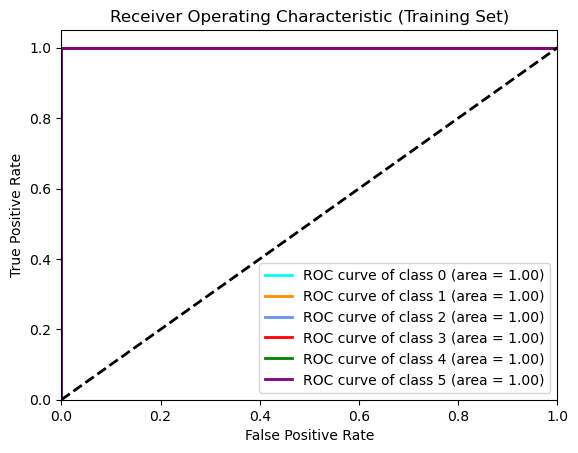

Test Accuracy: 0.8421052631578947
Test Error: 0.1578947368421053
Confusion Matrix on Test Set:
 [[3 0 0 1 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


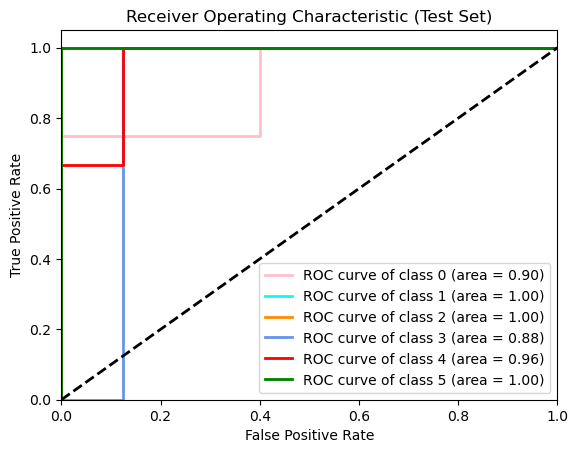

In [5]:
# Prepare the data using the best l
train_df, test_df = prepare_data(folders, test_instances, best_l)

X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Use the best RFE model
rfe = best_rfe
rfe.fit(X_train_standardized, y_train)

# Predictions on the training set
y_train_pred = rfe.predict(X_train_standardized)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Confusion Matrix on the training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix on Training Set:\n", conf_matrix_train)

# Calculate ROC AUC on the training set for multiclass
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_train_prob = rfe.predict_proba(X_train_standardized)
n_classes = y_train_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_bin.ravel(), y_train_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Training Set)')
plt.legend(loc="lower right")
plt.show()

# Predictions on the test set
y_test_pred = rfe.predict(X_test_standardized)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}")

# Confusion Matrix on the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix on Test Set:\n", conf_matrix_test)

# Calculate ROC AUC on the test set for multiclass
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_test_prob = rfe.predict_proba(X_test_standardized)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Compute micro-average ROC curve and ROC area
fpr_test["micro"], tpr_test["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_prob.ravel())
roc_auc_test["micro"] = auc(fpr_test["micro"], tpr_test["micro"])

# Plot ROC curve for each class on the test set
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_test[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.show()

For l=1, evaluating GaussianNB and MultinomialNB
For l=1: GaussianNB Cross-validation score = 0.7813186813186814
For l=1: MultinomialNB Cross-validation score = 0.7967032967032968
For l=2, evaluating GaussianNB and MultinomialNB
For l=2: GaussianNB Cross-validation score = 0.7692307692307692
For l=2: MultinomialNB Cross-validation score = 0.810989010989011
For l=3, evaluating GaussianNB and MultinomialNB
For l=3: GaussianNB Cross-validation score = 0.7252747252747251
For l=3: MultinomialNB Cross-validation score = 0.810989010989011
For l=4, evaluating GaussianNB and MultinomialNB
For l=4: GaussianNB Cross-validation score = 0.7538461538461538
For l=4: MultinomialNB Cross-validation score = 0.8252747252747253
For l=5, evaluating GaussianNB and MultinomialNB
For l=5: GaussianNB Cross-validation score = 0.8274725274725275
For l=5: MultinomialNB Cross-validation score = 0.8252747252747253
For l=6, evaluating GaussianNB and MultinomialNB
For l=6: GaussianNB Cross-validation score = 0.725274

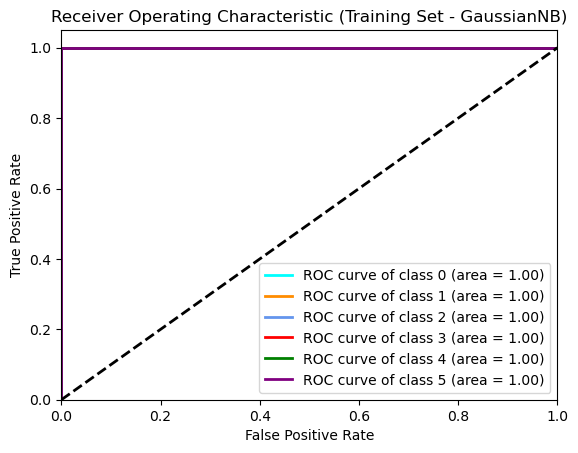

Training Accuracy (MultinomialNB): 0.9565217391304348
Confusion Matrix on Training Set (MultinomialNB):
 [[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  1 10  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


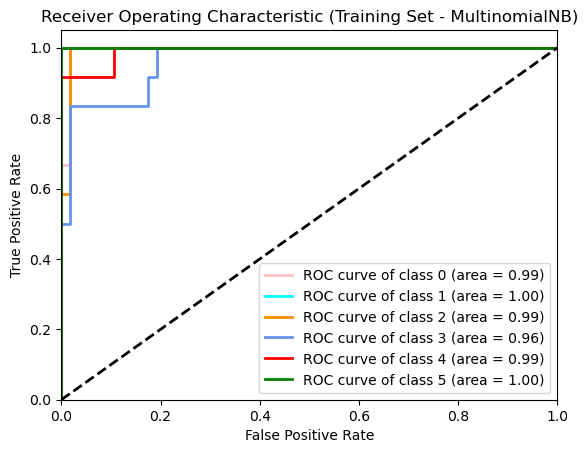

Test Accuracy (GaussianNB): 0.8947368421052632
Test Accuracy (MultinomialNB): 0.8947368421052632


In [9]:

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from joblib import Parallel, delayed


# Function to load and split instance data into l segments
def load_and_split_instance_data(folder, instance_index, l):
    file_path = os.path.join(base_path, folder, f"dataset{instance_index}.csv")
    df = pd.read_csv(file_path, skiprows=4)  # Skip the first 4 lines of metadata
    
    # Drop any columns containing 'time' in their names
    df = df.loc[:, ~df.columns.str.contains('time')]
    
    # Check for NaN values in the original DataFrame
    if df.isnull().values.any():
        print(f"NaN values found in original data for {folder}/dataset{instance_index}")
    
    # Verify the number of rows in the original DataFrame
    if df.shape[0] not in [479, 480]:
        print(f"Skipping instance {folder}/dataset{instance_index} due to unexpected row count: {df.shape[0]}")
        return None
    
    # Split each column into l segments
    segment_length = df.shape[0] // l
    segments = []
    for i in range(l):
        start = i * segment_length
        end = start + segment_length if i != l-1 else df.shape[0]
        segment = df.iloc[start:end].reset_index(drop=True)
        
        # Check for NaN values in the segments
        if segment.isnull().values.any():
            print(f"NaN values found in segment {i} for {folder}/dataset{instance_index}")
        
        segments.append(segment)
    
    return segments

# Function to extract time-domain features
def extract_features(segments):
    all_features = {}
    for i, segment in enumerate(segments):
        for col in segment.columns:
            all_features[f'{col}_mean_segment_{i}'] = segment[col].mean()
            all_features[f'{col}_std_segment_{i}'] = segment[col].std()
            all_features[f'{col}_median_segment_{i}'] = segment[col].median()
    return all_features

# Load, split, and extract features from the data
def prepare_data(folders, test_instances, l):
    def process_instance(folder, instance_index, l):
        segments = load_and_split_instance_data(folder, instance_index, l)
        if segments is not None:
            features = extract_features(segments)
            # Combine bending1 and bending2 into a single class "bending"
            activity = "bending" if folder in ["bending1", "bending2"] else folder
            features['Activity'] = activity
            if instance_index in test_instances[folder]:
                return 'test', features
            else:
                return 'train', features
        return None

    results = Parallel(n_jobs=-1)(delayed(process_instance)(folder, instance_index, l) for folder in folders for instance_index in range(1, len(os.listdir(os.path.join(base_path, folder))) + 1))
    train_data = [result[1] for result in results if result and result[0] == 'train']
    test_data = [result[1] for result in results if result and result[0] == 'test']

    return pd.DataFrame(train_data), pd.DataFrame(test_data)

# Train and evaluate model with Naive Bayes
def train_and_evaluate_model(X, y, model, k=5):
    # Handle NaN values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    # Standardize the features for GaussianNB
    if isinstance(model, GaussianNB):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=k)
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    mean_score = np.mean(scores)
    
    return mean_score, model

# Main logic to find the best l
results_gaussian = []
results_multinomial = []
best_gaussian_model = None
best_multinomial_model = None

for l in range(1, 20):  
    train_df, test_df = prepare_data(folders, test_instances, l)
    
    X_train = train_df.drop('Activity', axis=1)
    y_train = train_df['Activity']
    
    print(f"For l={l}, evaluating GaussianNB and MultinomialNB")  # Print current evaluation
    
    # Gaussian Naive Bayes
    gaussian_nb = GaussianNB()
    mean_score_gaussian, gaussian_nb_model = train_and_evaluate_model(X_train, y_train, gaussian_nb)
    results_gaussian.append((l, mean_score_gaussian))
    if mean_score_gaussian == max(results_gaussian, key=lambda x: x[1])[1]:
        best_gaussian_model = gaussian_nb_model
    
    # Multinomial Naive Bayes
    multinomial_nb = MultinomialNB()
    mean_score_multinomial, multinomial_nb_model = train_and_evaluate_model(X_train, y_train, multinomial_nb)
    results_multinomial.append((l, mean_score_multinomial))
    if mean_score_multinomial == max(results_multinomial, key=lambda x: x[1])[1]:
        best_multinomial_model = multinomial_nb_model
    
    print(f'For l={l}: GaussianNB Cross-validation score = {mean_score_gaussian}')
    print(f'For l={l}: MultinomialNB Cross-validation score = {mean_score_multinomial}')

# Find the best model based on cross-validation score
best_result_gaussian = max(results_gaussian, key=lambda x: x[1])
best_l_gaussian, best_cv_score_gaussian = best_result_gaussian

best_result_multinomial = max(results_multinomial, key=lambda x: x[1])
best_l_multinomial, best_cv_score_multinomial = best_result_multinomial

# Output the results
print("\nGaussianNB - Optimal number of segments (l) and cross-validation score:")
for result in results_gaussian:
    l, mean_score = result
    if l == best_l_gaussian:
        print(f"Optimal number of segments for l = {l}")
        print(f"Cross-validation score: {mean_score}")

print(f"\nBest GaussianNB model: l = {best_l_gaussian}")
print(f"Cross-validation score = {best_cv_score_gaussian}")

print("\nMultinomialNB - Optimal number of segments (l) and cross-validation score:")
for result in results_multinomial:
    l, mean_score = result
    if l == best_l_multinomial:
        print(f"Optimal number of segments for l = {l}")
        print(f"Cross-validation score: {mean_score}")

print(f"\nBest MultinomialNB model: l = {best_l_multinomial}")
print(f"Cross-validation score = {best_cv_score_multinomial}")

# Prepare the data using the best l for GaussianNB
train_df, test_df = prepare_data(folders, test_instances, best_l_gaussian)

X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

# Standardize the features for GaussianNB
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Train the best GaussianNB model on the training set
best_gaussian_model.fit(X_train_standardized, y_train)

# Predictions on the training set
y_train_pred_gaussian = best_gaussian_model.predict(X_train_standardized)

# Calculate accuracy on the training set
train_accuracy_gaussian = accuracy_score(y_train, y_train_pred_gaussian)
print(f"Training Accuracy (GaussianNB): {train_accuracy_gaussian}")

# Confusion Matrix on the training set
conf_matrix_train_gaussian = confusion_matrix(y_train, y_train_pred_gaussian)
print("Confusion Matrix on Training Set (GaussianNB):\n", conf_matrix_train_gaussian)

# Calculate ROC AUC on the training set for GaussianNB
y_train_bin_gaussian = label_binarize(y_train, classes=np.unique(y_train))
y_train_prob_gaussian = best_gaussian_model.predict_proba(X_train_standardized)
n_classes_gaussian = y_train_bin_gaussian.shape[1]

# Compute ROC curve and ROC area for each class
fpr_gaussian = dict()
tpr_gaussian = dict()
roc_auc_gaussian = dict()
for i in range(n_classes_gaussian):
    fpr_gaussian[i], tpr_gaussian[i], _ = roc_curve(y_train_bin_gaussian[:, i], y_train_prob_gaussian[:, i])
    roc_auc_gaussian[i] = auc(fpr_gaussian[i], tpr_gaussian[i])

# Compute micro-average ROC curve and ROC area
fpr_gaussian["micro"], tpr_gaussian["micro"], _ = roc_curve(y_train_bin_gaussian.ravel(), y_train_prob_gaussian.ravel())
roc_auc_gaussian["micro"] = auc(fpr_gaussian["micro"], tpr_gaussian["micro"])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'pink'])
for i, color in zip(range(n_classes_gaussian), colors):
    plt.plot(fpr_gaussian[i], tpr_gaussian[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_gaussian[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Training Set - GaussianNB)')
plt.legend(loc="lower right")
plt.show()

# Train the best MultinomialNB model on the training set
best_multinomial_model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred_multinomial = best_multinomial_model.predict(X_train)

# Calculate accuracy on the training set
train_accuracy_multinomial = accuracy_score(y_train, y_train_pred_multinomial)
print(f"Training Accuracy (MultinomialNB): {train_accuracy_multinomial}")

# Confusion Matrix on the training set
conf_matrix_train_multinomial = confusion_matrix(y_train, y_train_pred_multinomial)
print("Confusion Matrix on Training Set (MultinomialNB):\n", conf_matrix_train_multinomial)

# Calculate ROC AUC on the training set for MultinomialNB
y_train_bin_multinomial = label_binarize(y_train, classes=np.unique(y_train))
y_train_prob_multinomial = best_multinomial_model.predict_proba(X_train)
n_classes_multinomial = y_train_bin_multinomial.shape[1]

# Compute ROC curve and ROC area for each class
fpr_multinomial = dict()
tpr_multinomial = dict()
roc_auc_multinomial = dict()
for i in range(n_classes_multinomial):
    fpr_multinomial[i], tpr_multinomial[i], _ = roc_curve(y_train_bin_multinomial[:, i], y_train_prob_multinomial[:, i])
    roc_auc_multinomial[i] = auc(fpr_multinomial[i], tpr_multinomial[i])

# Compute micro-average ROC curve and ROC area
fpr_multinomial["micro"], tpr_multinomial["micro"], _ = roc_curve(y_train_bin_multinomial.ravel(), y_train_prob_multinomial.ravel())
roc_auc_multinomial["micro"] = auc(fpr_multinomial["micro"], tpr_multinomial["micro"])

# Plot ROC curve for each class
plt.figure()
for i, color in zip(range(n_classes_multinomial), colors):
    plt.plot(fpr_multinomial[i], tpr_multinomial[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_multinomial[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Training Set - MultinomialNB)')
plt.legend(loc="lower right")
plt.show()

# Test accuracy for GaussianNB
y_test_pred_gaussian = best_gaussian_model.predict(X_test_standardized)
test_accuracy_gaussian = accuracy_score(y_test, y_test_pred_gaussian)
print(f"Test Accuracy (GaussianNB): {test_accuracy_gaussian}")

# Test accuracy for MultinomialNB
y_test_pred_multinomial = best_multinomial_model.predict(X_test)
test_accuracy_multinomial = accuracy_score(y_test, y_test_pred_multinomial)
print(f"Test Accuracy (MultinomialNB): {test_accuracy_multinomial}")


Training Accuracy: 0.9565217391304348
Confusion Matrix on Training Set:
 [[ 8  0  0  1  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  2 10  0]
 [ 0  0  0  0  0 12]]


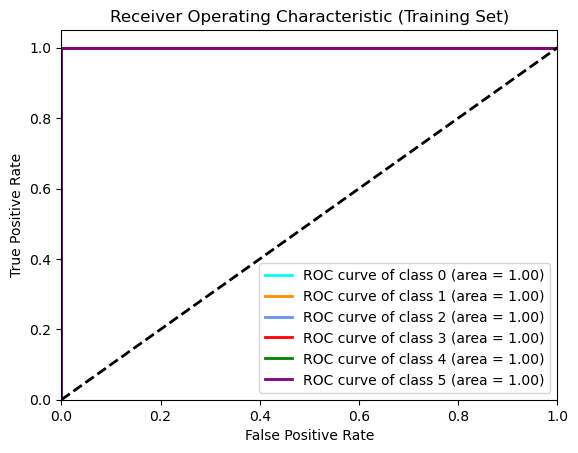

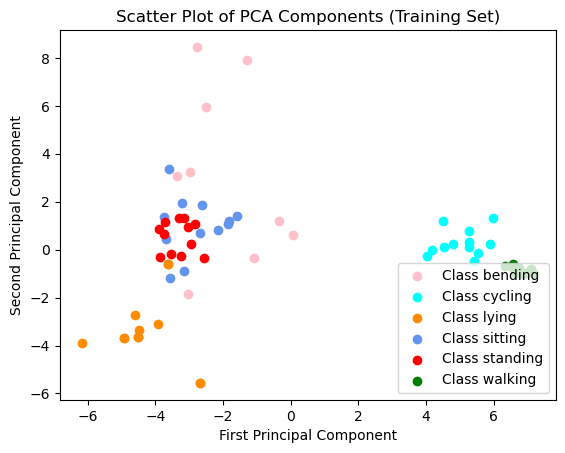

Test Accuracy: 0.8421052631578947
Test Error: 0.1578947368421053
Confusion Matrix on Test Set:
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


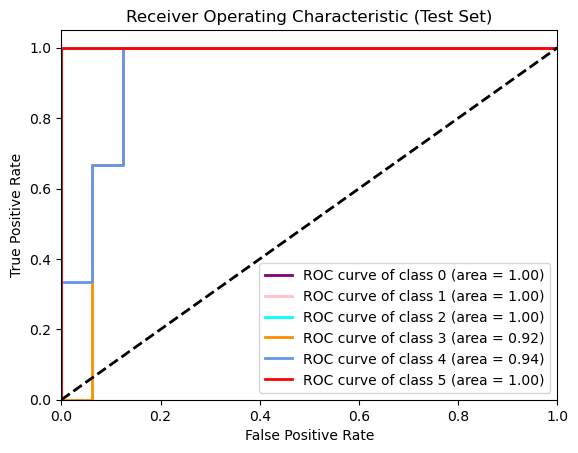

In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

best_l = 2  
best_p = 10   


train_df, test_df = prepare_data(folders, test_instances, best_l)

X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Perform PCA
pca = PCA(n_components=best_p)
X_train_pca = pca.fit_transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)

# Train the Naive Bayes model on the PCA-transformed data
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_pca, y_train)

# Predictions on the training set
y_train_pred = naive_bayes.predict(X_train_pca)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Confusion Matrix on the training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix on Training Set:\n", conf_matrix_train)

# Calculate ROC AUC on the training set
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_train_prob = naive_bayes.predict_proba(X_train_pca)
n_classes = y_train_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_bin.ravel(), y_train_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Training Set)')
plt.legend(loc="lower right")
plt.show()

# Scatter plot of the first and second principal components
plt.figure()
for i, color in zip(np.unique(y_train), colors):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1], color=color, label=f'Class {i}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Scatter Plot of PCA Components (Training Set)')
plt.legend(loc="lower right")
plt.show()

# Predictions on the test set
y_test_pred = naive_bayes.predict(X_test_pca)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}")

# Confusion Matrix on the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix on Test Set:\n", conf_matrix_test)

# Calculate ROC AUC on the test set for multiclass
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_test_prob = naive_bayes.predict_proba(X_test_pca)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Compute micro-average ROC curve and ROC area
fpr_test["micro"], tpr_test["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_prob.ravel())
roc_auc_test["micro"] = auc(fpr_test["micro"], tpr_test["micro"])

# Plot ROC curve for each class
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_test[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc="lower right")
plt.show()


Based on the results above:

L1-Penalized Logistic Regression:
Best Model: 
l=2, 
𝑝=10

Cross-Validation Score: 0.9132
Test Accuracy: 0.8421
Test Error: 0.1579

Gaussian Naive Bayes:
Best Model: 
l=5
Cross-Validation Score: 0.8275
Test Accuracy: 0.8421
Test Error: 0.1579
Training Accuracy: 0.9710

Multinomial Naive Bayes:
Best Model: 
l=4
Cross-Validation Score: 0.8252
Test Accuracy: 0.8421
Test Error: 0.1579

PCA:
Test Accuracy: 0.8421
Test Error: 0.1579

Comparison:
L1-Penalized Logistic Regression:

Has the highest cross-validation score among all models.
Implementation was more complex and time consuming due to the need for hyperparameter tuning (number of features and regularization parameter).


Gaussian Naive Bayes:
Simpler to implement compared to logistic regression but slightly lower cross-validation score.

Multinomial Naive Bayes:
Also simpler to implement but has the lowest cross-validation score.


PCA with Naive Bayes:
Test accuracy: 0.8421
Using PCA can reduce dimensionality and may be beneficial for some datasets.
Conclusion:
L1-Penalized Logistic Regression is the best model in terms of cross-validation performance.
Gaussian Naive Bayes is simpler to implement and performs well but with a slightly lower cross-validation score.
The test accuracies for all models are similar, but the logistic regression model demonstrated better performance during cross-validation.
For this specific problem, if we prioritize model performance based on cross-validation, we can go with L1-Penalized Logistic Regression. If ease of implementation is more important, Gaussian Naive Bayes is the best model

Reference:
Used ChatGPT to implement parallel logic code to fasten the training process. 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html

https://stackoverflow.com/questions/78148150/multiclass-classfication-on-small-imbalanced-data

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://datascience.stackexchange.com/questions/89180/can-micro-average-roc-auc-score-be-larger-than-class-roc-auc-scores

https://stackoverflow.com/questions/77789793/computing-auc-and-roc-curve-with-micro-and-macro-average-on-multi-class-data-i